In [1]:
import numpy as np
import pandas as pd
import os
import re
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.Draw as Draw
from graph_attribution.datasets import save_graphtuples, load_graphstuples
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import rdkit.Chem.AllChem as Chem
from rdkit import DataStructs
import json
import pandas as pd
import numpy as np
from graphdot.model.gaussian_process import GaussianProcessRegressor as GPR
from mgktools.data.data import Dataset
from mgktools.kernels.utils import get_kernel_config
from mgktools.interpret.interpret import interpret_training_mols, interpret_atoms
from mgktools.hyperparameters import *
from mgktools.hyperparameters.hyperopt import bayesian_optimization
from mgktools.evaluators.cross_validation import Evaluator
from mgktools.features_mol.features_generators import FeaturesGenerator
from sklearn.metrics import mean_squared_error
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from IPython.display import display
from scipy import stats

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

2023-01-12 16:09:19.902762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 16:09:20.540221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/cuda/11.6/lib64:/home/xiangyan/workspace/apps/cuda/11.6/lib64:
2023-01-12 16:09:20.540275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/cuda/11

rdkit detected? True


# Table S1

In [2]:
df = pd.read_csv('../../../data/results/F3_hparams_raw.csv')
df_gnn = pd.DataFrame({'dataset': [], 'model': [], 'method': [], 'AUROC mean': [], 'AUROC std': [],
                       'ATT AUROC mean': [], 'ATT AUROC std': []})
for dataset in ['logic7', 'logic8', 'logic10', 'benzene']:
    for bt in df.block_type.unique():
        for t in df.Technique.unique():
            df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
            df_gnn.loc[len(df_gnn)] = dataset, bt, t, df_['AUROC'].mean(), df_['AUROC'].std(), df_['ATT AUROC'].mean(), df_['ATT AUROC'].std()
df_gnn.to_csv('gnn_all.csv', index=False)

df_gnn = pd.DataFrame({'dataset': [], 'model': [], 'method': [], 'AUROC mean': [], 'AUROC std': [],
                       'ATT AUROC mean': [], 'ATT AUROC std': []})
for dataset in ['logic7', 'logic8', 'logic10', 'benzene']:
    for bt in df.block_type.unique():
        for t in df.Technique.unique():
            df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
            idx = df_.sort_values('AUROC').iloc[int(0.9*len(df_)):].index
            df_ = df_[df_.index.isin(idx)]
            df_gnn.loc[len(df_gnn)] = dataset, bt, t, df_['AUROC'].mean(), df_['AUROC'].std(), df_['ATT AUROC'].mean(), df_['ATT AUROC'].std()
df_gnn.to_csv('gnn_10%.csv', index=False)

In [3]:
# table S1
df_mgk = pd.read_csv('../results/figure_data/hyperopt.csv')
for dataset, n_splits in [('logic7', 38), ('logic8', 77), ('logic10', 77), ('benzene', 100)]:
    d1 = df_mgk[(df_mgk.dataset==dataset) & (df_mgk.n_subsets==n_splits)]['auc_pred']
    print('GPR-MGK, %s, prediction ROC-AUC: %.3f +/- %.3f' % (dataset, d1.mean(), d1.std()))
    for model in ['mpnn', 'gcn', 'gat']:
        d1 = df_gnn[(df_gnn.dataset==dataset) & (df_gnn.model == model)].iloc[0]
        print('%s, %s, prediction ROC-AUC: %.3f +/- %.3f' % (model, dataset, d1['AUROC mean'], d1['AUROC std']))

GPR-MGK, logic7, prediction ROC-AUC: 0.973 +/- 0.001
mpnn, logic7, prediction ROC-AUC: 0.987 +/- 0.001
gcn, logic7, prediction ROC-AUC: 0.989 +/- 0.002
gat, logic7, prediction ROC-AUC: 0.992 +/- 0.002
GPR-MGK, logic8, prediction ROC-AUC: 0.990 +/- 0.002
mpnn, logic8, prediction ROC-AUC: 0.980 +/- 0.002
gcn, logic8, prediction ROC-AUC: 0.980 +/- 0.002
gat, logic8, prediction ROC-AUC: 0.987 +/- 0.002
GPR-MGK, logic10, prediction ROC-AUC: 0.964 +/- 0.004
mpnn, logic10, prediction ROC-AUC: 0.977 +/- 0.001
gcn, logic10, prediction ROC-AUC: 0.975 +/- 0.002
gat, logic10, prediction ROC-AUC: 0.968 +/- 0.002
GPR-MGK, benzene, prediction ROC-AUC: 1.000 +/- 0.000
mpnn, benzene, prediction ROC-AUC: 1.000 +/- 0.000
gcn, benzene, prediction ROC-AUC: 1.000 +/- 0.000
gat, benzene, prediction ROC-AUC: 1.000 +/- 0.000


logic7
Ttest_indResult(statistic=16.333449476758158, pvalue=2.442937472484344e-10)
Ttest_indResult(statistic=12.962482103686412, pvalue=2.5071660989630446e-12)
Ttest_indResult(statistic=10.03224542725188, pvalue=1.1698709068126684e-13)
Ttest_indResult(statistic=20.638137114435896, pvalue=1.1537628653376846e-18)
logic8
Ttest_indResult(statistic=4.244630576683737, pvalue=0.0017237854138192493)
Ttest_indResult(statistic=33.173653236553996, pvalue=8.483990341085389e-68)
Ttest_indResult(statistic=21.787410013009733, pvalue=1.3724838015711943e-39)
Ttest_indResult(statistic=47.26015629712972, pvalue=1.1667640264778471e-54)
logic10
Ttest_indResult(statistic=2.4179025433008294, pvalue=0.035824840702297744)
Ttest_indResult(statistic=3.342609349519801, pvalue=0.00100309568381685)
Ttest_indResult(statistic=6.038195191918722, pvalue=1.886036058954581e-08)
Ttest_indResult(statistic=16.543106868956517, pvalue=2.309354367511577e-31)
benzene
Ttest_indResult(statistic=8.937127266778793, pvalue=2.3460474

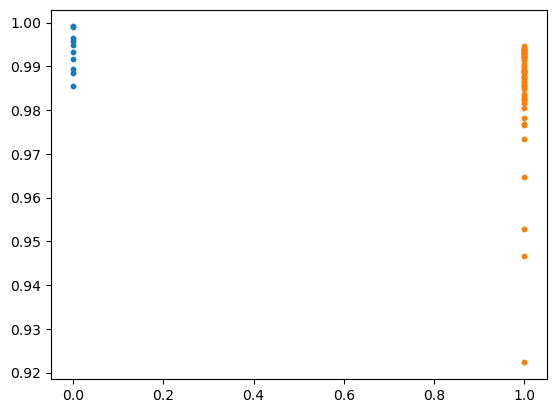

In [4]:
# t test of GPR-MGK and GNNs.
df = pd.read_csv('../../../data/results/F3_hparams_raw.csv')
df1 = pd.read_csv('../results/figure_data/hyperopt.csv')
for dataset in ['logic7']:
    print(dataset)
    att1 = df1[(df1.dataset==dataset) & (df1.n_subsets==38)]['auc_att'].tolist()
    for bt, t in [['mpnn', 'CAM'], ['gcn', 'CAM'], ['gcn', 'IG'], ['gat', 'CAM']]:
        df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
        idx = df_.sort_values('AUROC').iloc[int(0.9*len(df_)):].index
        df_ = df_[df_.index.isin(idx)]
        att2 = df_['ATT AUROC'].tolist()
        print(stats.ttest_ind(att1, att2, equal_var=False))

for dataset in ['logic8', 'logic10']:
    print(dataset)
    bt, t = ['mpnn', 'CAM']
    df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
    idx = df_.sort_values('AUROC').iloc[int(0.9*len(df_)):].index
    df_ = df_[df_.index.isin(idx)]
    att1 = df_['ATT AUROC'].tolist()
    
    att2 = df1[(df1.dataset==dataset) & (df1.n_subsets==77)]['auc_att'].tolist()
    print(stats.ttest_ind(att1, att2, equal_var=False))
    for bt, t in [['gcn', 'CAM'], ['gcn', 'IG'], ['gat', 'CAM']]:
        df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
        idx = df_.sort_values('AUROC').iloc[int(0.9*len(df_)):].index
        df_ = df_[df_.index.isin(idx)]
        att2 = df_['ATT AUROC'].tolist()
        print(stats.ttest_ind(att1, att2, equal_var=False))

for dataset in ['benzene']:
    print(dataset)
    att1 = df1[(df1.dataset==dataset) & (df1.n_subsets==100)]['auc_att'].tolist()
    for bt, t in [['mpnn', 'CAM'], ['gcn', 'CAM'], ['gcn', 'IG'], ['gat', 'CAM']]:
        df_ = df[(df.task_type == dataset)&(df.block_type == bt)&(df.Technique == t)]
        idx = df_.sort_values('AUROC').iloc[int(0.9*len(df_)):].index
        df_ = df_[df_.index.isin(idx)]
        att2 = df_['ATT AUROC'].tolist()
        print(stats.ttest_ind(att1, att2, equal_var=False))

plt.scatter([0.]*len(att1), att1, s=10)
plt.scatter([1.]*len(att2), att2, s=10)

# Atomic Attribution

# Figure S1

In [5]:
df = pd.read_csv('../results/figure_data/hyperopt.csv')
df

dataset  n_subsets  auc_pred   auc_att  seed
0     logic7          1   0.98948  0.904723     0
1     logic7          1   0.98919  0.847454     1
2     logic7          1   0.99113  0.738418     2
3     logic7          1   0.98817  0.911576     3
4     logic7          1   0.99036  0.876132     4
..       ...        ...       ...       ...   ...
305  benzene        200   0.99990  0.998295     5
306  benzene        200   0.99994  0.995585     6
307  benzene        200   0.99993  0.997830     7
308  benzene        200   0.99999  0.997284     8
309  benzene        200   0.99999  0.996484     9

[310 rows x 5 columns]

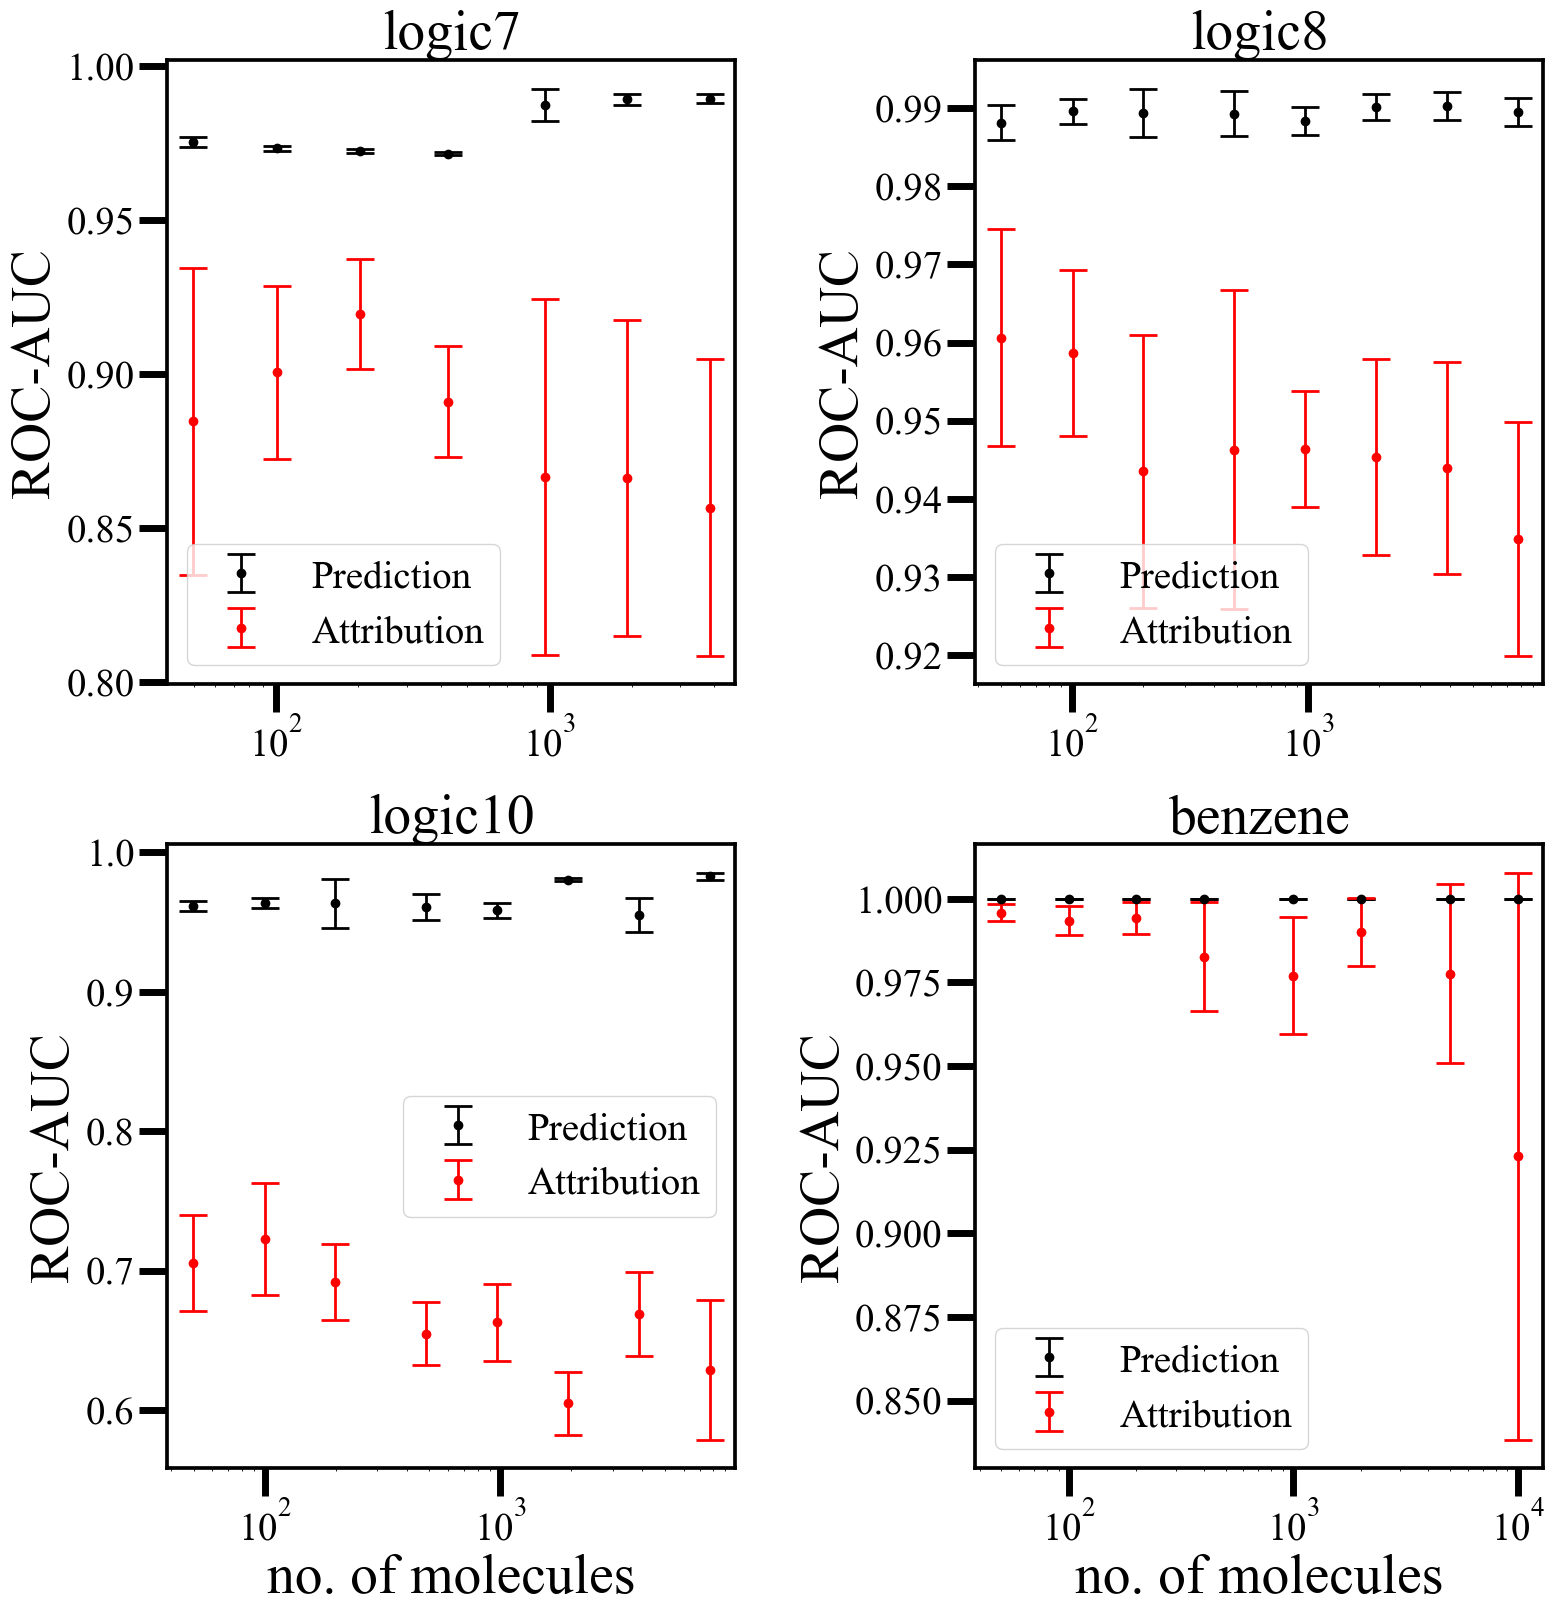

In [6]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 2, fs * 2),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

dxs = [0.10, 0.15, 0.04]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.08, 0.1, 0.04]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

df = pd.read_csv('../results/figure_data/hyperopt.csv')

nx = 1
ny = 2
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic7'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [3840 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()

ax.set_xscale('log')
ax.set_title(dataset)

nx = 2
ny = 2
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic8'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [7753 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()

ax.set_xscale('log')
ax.set_title(dataset)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic10'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [7718 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('no. of molecules')
ax.set_title(dataset)

nx = 2
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'benzene'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [10000 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('no. of molecules')
ax.set_title(dataset)

plt.savefig('figure1.png')

# Figure S2

smiles: CC(=C)C[NH2+]C[C@]1(CCCN(C1=O)Cc1cccc(c1F)F)O
ZINC: ZINC11999481
0.81707495
0.883134
smiles: C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)Nc1ccc(cn1)Br
ZINC: ZINC72003911
0.88207996
0.758253


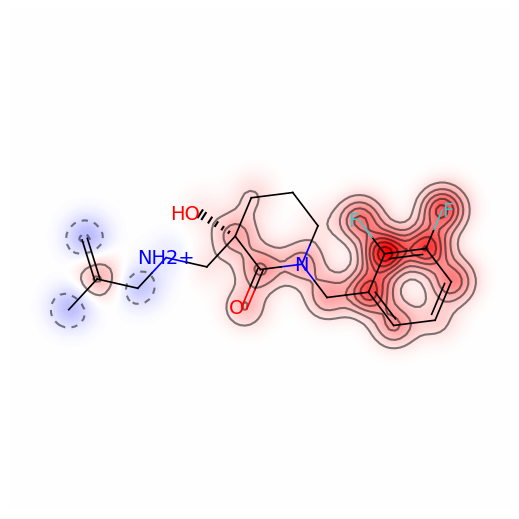

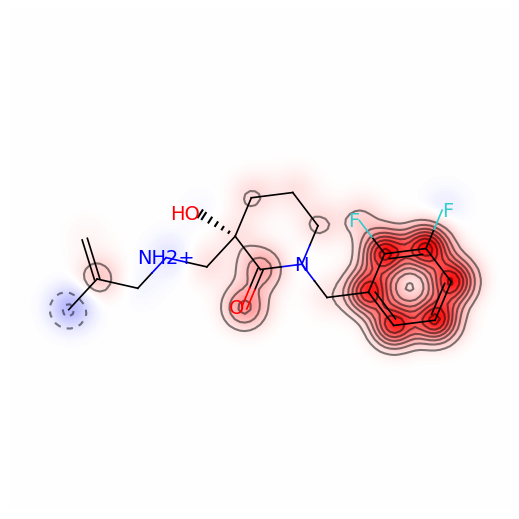

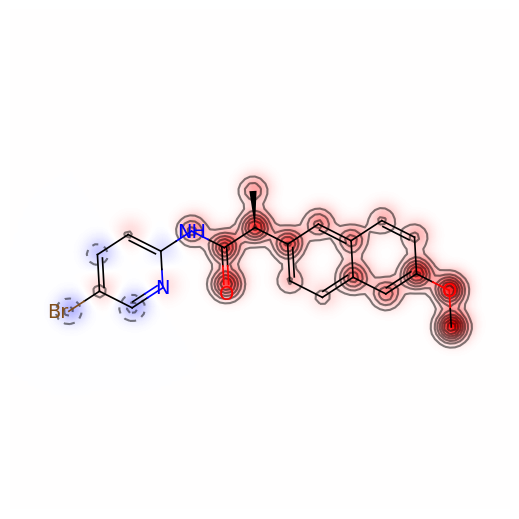

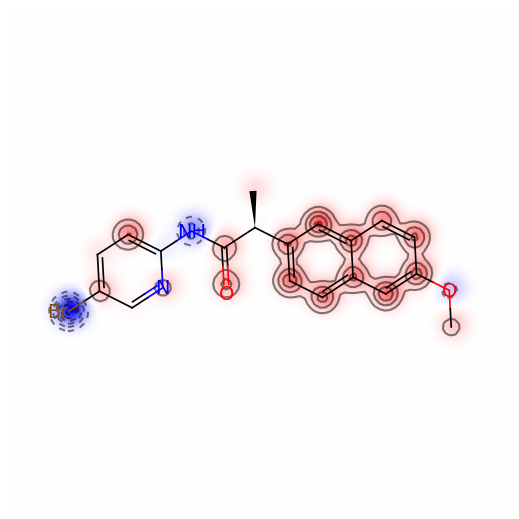

In [7]:
df_test = pd.read_csv('../results/raw_data/benzene/test.csv')

ids = [1, 100]
for i in ids:
    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_1/9/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)
    smiles = df_test.smiles[i]
    print('smiles: %s' % smiles)
    print('ZINC: %s' % df_test.mol_id[i])
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, alpha=0.5, size=(200, 200))
    # Draw.MolToImage(mol, size=(800, 500))

    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_100/0/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)

    smiles = df_test.smiles[i]
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, size=(200, 200))
    # Draw.MolToImage(mol, size=(500, 300))

# Molecular Attribution

In [8]:
# hyperparameter optimization
df = pd.read_csv('0_scaffold_order_train_size321.csv')
if not os.path.exists('hyperopt-graph/hyperparameters_0.json'):
    dataset = Dataset.from_df(df=df,
                              pure_columns=['smiles'],
                              target_columns=['freesolv'])
    dataset.graph_kernel_type = 'graph'
    kernel_config = get_kernel_config(dataset=dataset,
                                      graph_kernel_type='graph',
                                      mgk_hyperparameters_files=[additive_pnorm])
    best_hyperdict, results, hyperdicts = bayesian_optimization(save_dir='hyperopt-graph',
                                                                datasets=[dataset],
                                                                kernel_config=kernel_config,
                                                                model_type='gpr',
                                                                task_type='regression',
                                                                metric='rmse',
                                                                split_type='loocv',
                                                                num_iters=100,
                                                                alpha=0.01)

if not os.path.exists('hyperopt-morgan/features_hyperparameters.json'):
    dataset = Dataset.from_df(df=df,
                              pure_columns=['smiles'],
                              target_columns=['freesolv'],
                              features_generator=['morgan'])
    dataset.graph_kernel_type = None
    kernel_config = get_kernel_config(dataset=dataset,
                                      graph_kernel_type=None,
                                      features_kernel_type='rbf',
                                      features_hyperparameters=[1.0],
                                      features_hyperparameters_bounds=[(0.1, 10.0)],
                                      )
    best_hyperdict, results, hyperdicts = bayesian_optimization(save_dir='hyperopt-morgan',
                                                                datasets=[dataset],
                                                                kernel_config=kernel_config,
                                                                model_type='gpr',
                                                                task_type='regression',
                                                                metric='rmse',
                                                                split_type='loocv',
                                                                num_iters=100,
                                                                alpha=0.01)
# Prediction
df_test = pd.read_csv('0_scaffold_order_test_size321.csv')
train = Dataset.from_df(df=df, 
                        pure_columns=['smiles'], 
                        target_columns=['freesolv'])
train.graph_kernel_type = 'graph'
test = Dataset.from_df(df=df_test, 
                       pure_columns=['smiles'], 
                       target_columns=['freesolv'])
test.graph_kernel_type = 'graph'
kernel_config = get_kernel_config(dataset=train,
                                  graph_kernel_type='graph',
                                  mgk_hyperparameters_files=['hyperopt-graph/hyperparameters_0.json'])
gpr = GPR(kernel=kernel_config.kernel,
          optimizer=None,
          alpha=0.01,)
gpr.fit(train.X, train.y)
y_pred_mgk = gpr.predict(test.X)
# rmse(test.y, y_pred_mgk)

train = Dataset.from_df(df=df, 
                        pure_columns=['smiles'], 
                        target_columns=['freesolv'],
                       features_generator=['morgan'])
test = Dataset.from_df(df=df_test, 
                       pure_columns=['smiles'], 
                       target_columns=['freesolv'], features_generator=['morgan'])
kernel_config = get_kernel_config(dataset=train,
                                  graph_kernel_type=None,
                                  features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json'
                                  )
gpr = GPR(kernel=kernel_config.kernel,
          optimizer=None,
          alpha=0.01,)
gpr.fit(train.X, train.y)
y_pred_morgan = gpr.predict(test.X)
# rmse(test.y, y_pred_morgan)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.0s finished


# Figure 1

rmse of GPR-MGK= 2.7528236899199667
rmse of GPR-RBF-Morgan= 4.068158997125349


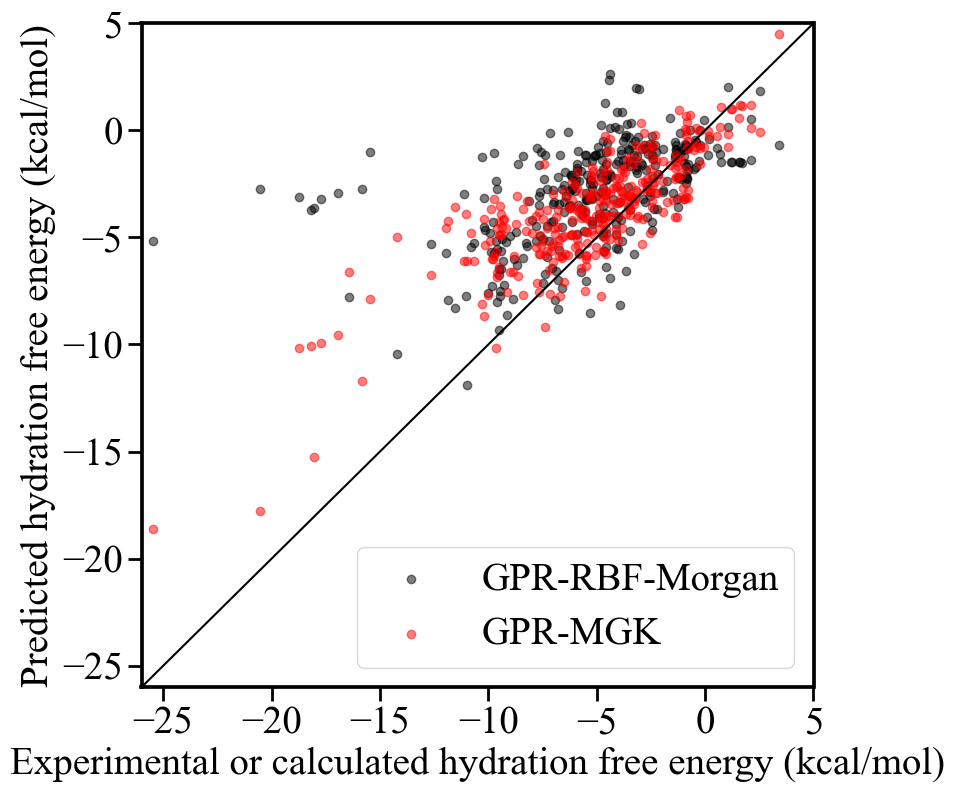

In [9]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 1.2, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (3.5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

dxs = [0.15, 0.15]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.15, 0.02]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=2, length=10)
print('rmse of GPR-MGK=', rmse(test.y, y_pred_mgk))
print('rmse of GPR-RBF-Morgan=', rmse(test.y, y_pred_morgan))
ax.scatter(test.y, y_pred_morgan, label='GPR-RBF-Morgan', alpha=0.5, c='k')
ax.scatter(test.y, y_pred_mgk, label='GPR-MGK', alpha=0.5, c='r')
ax.set_xlabel('Experimental or calculated hydration free energy (kcal/mol)')
ax.set_ylabel('Predicted hydration free energy (kcal/mol)')
ax.plot([-30, 5], [-30, 5], 'k')
ax.legend()
ax.set_xlim([-26, 5])
ax.set_ylim([-26, 5])
ax.set_xticks(range(-25, 10, 5))

plt.savefig('figure1.png')

# Figure 2

In [10]:
df = pd.read_csv('0_scaffold_order_train_size321.csv')
smiles_list = df_test.sort_values('freesolv')[:5].smiles.tolist()
df_test.sort_values('freesolv')[:5]
smiles_train = df['smiles']
targets_train = df['freesolv']
alpha = 0.01
n_mol = 10000
for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    Draw.MolToImageFile(mol, 'mol_%d.png' % i)

In [11]:
df_test.sort_values('freesolv')

smiles  freesolv
177  C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O    -25.47
103            C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O    -20.52
102                        c1c(c(=O)[nH]c(=O)[nH]1)I    -18.72
37                        c1c(c(=O)[nH]c(=O)[nH]1)Br    -18.17
78                     c1(=O)[nH]c(=O)[nH]c(=O)[nH]1    -18.06
..                                               ...       ...
135                                        CC1CCCCC1      1.70
195                                     CC1CCC(CC1)C      2.11
273                                       CCCC1CCCC1      2.13
255                                     CCCCCC1CCCC1      2.55
265                     C1(C(C(C1(F)F)(F)F)(F)F)(F)F      3.43

[321 rows x 2 columns]

In [12]:
smiles_to_be_interpret = smiles_list[0]
mol = Chem.MolFromSmiles(smiles_to_be_interpret)
y_pred, y_std, df_interpret= interpret_training_mols(
    smiles_to_be_interpret, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file='hyperopt-graph/hyperparameters_0.json',
    n_jobs=1, return_kernel=True)
df_interpret = df_interpret[0]
df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
    x.contribution_value / x.contribution_percentage, 
    x.contribution_percentage, 
    x.contribution_value), axis=1)
df_interpret_mgk = df_interpret

y_pred, y_std, df_interpret= interpret_training_mols(
    smiles_to_be_interpret, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file=None,
    features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json',
    features_generator = ['morgan'],
    n_jobs=1, return_kernel=True)
df_interpret = df_interpret[0]
df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
    x.contribution_value / x.contribution_percentage, 
    x.contribution_percentage, 
    x.contribution_value), axis=1)
df_interpret_morgan = df_interpret

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.7s finished


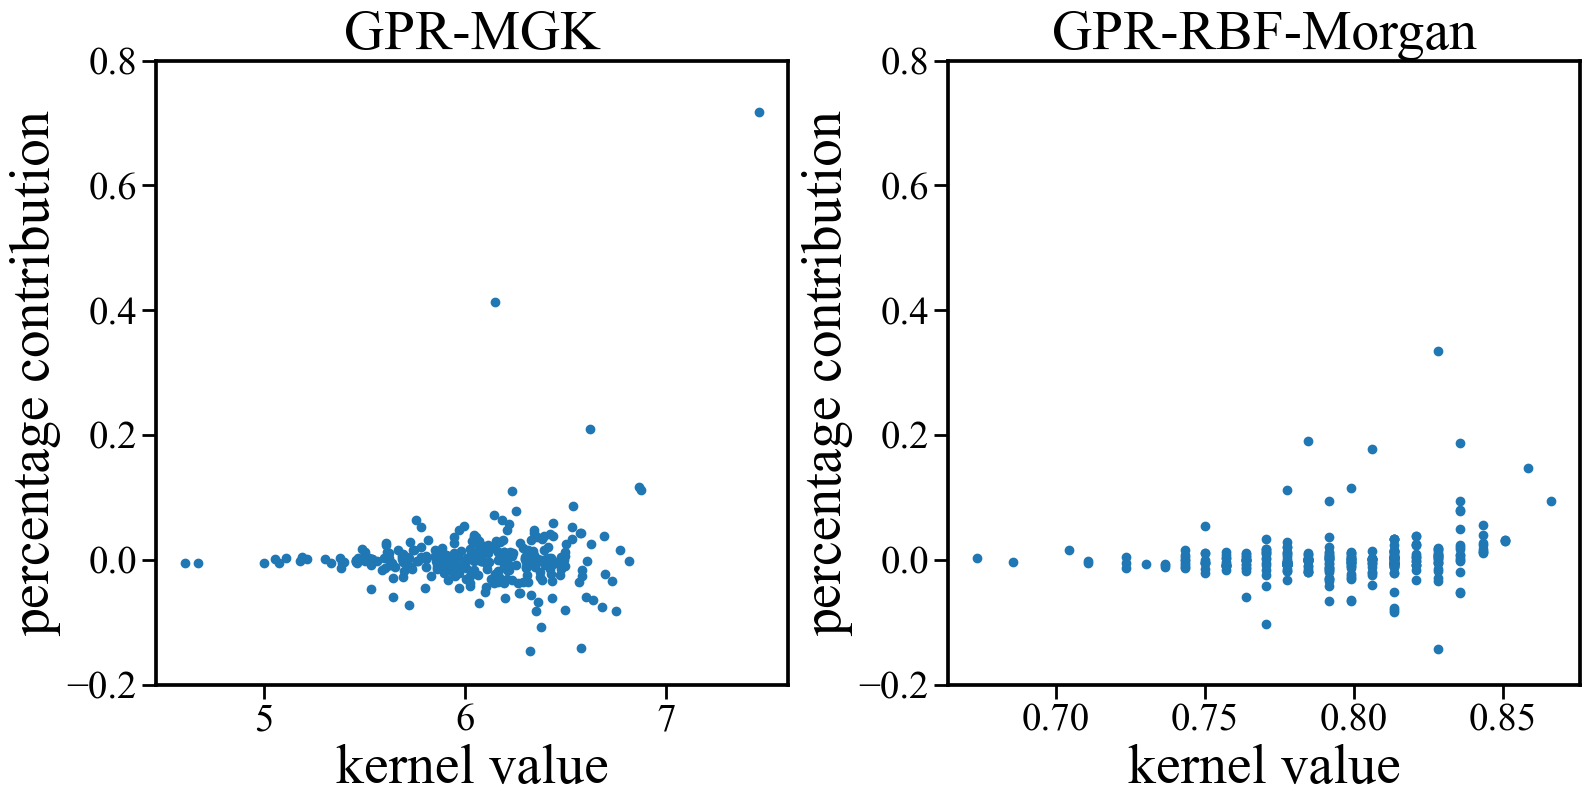

In [13]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 2, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

dxs = [0.10, 0.10, 0.01]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.14, 0.08]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=2, length=10)       
ax.scatter(df_interpret_mgk['kernel'], df_interpret_mgk['contribution_percentage'])                                    
ax.set_xlabel('kernel value')
ax.set_ylabel('percentage contribution')
ax.set_ylim([-0.2, 0.8])
ax.set_title('GPR-MGK')

nx = 2
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=2, length=10)       
ax.scatter(df_interpret_morgan['kernel'], df_interpret_morgan['contribution_percentage'])                                    
ax.set_xlabel('kernel value')
ax.set_ylabel('percentage contribution')
ax.set_ylim([-0.2, 0.8])
ax.set_title('GPR-RBF-Morgan')

plt.savefig('figure2.png')

# Figure S3-S12

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.9s finished


Z-score of the most important molecule is:  12.61800174719587


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.5s finished


Z-score of the most important molecule is:  11.07189572321361


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


Z-score of the most important molecule is:  10.696580903234798


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.3s finished


Z-score of the most important molecule is:  10.68044975464378


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.6s finished


Z-score of the most important molecule is:  7.761771048664388


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(


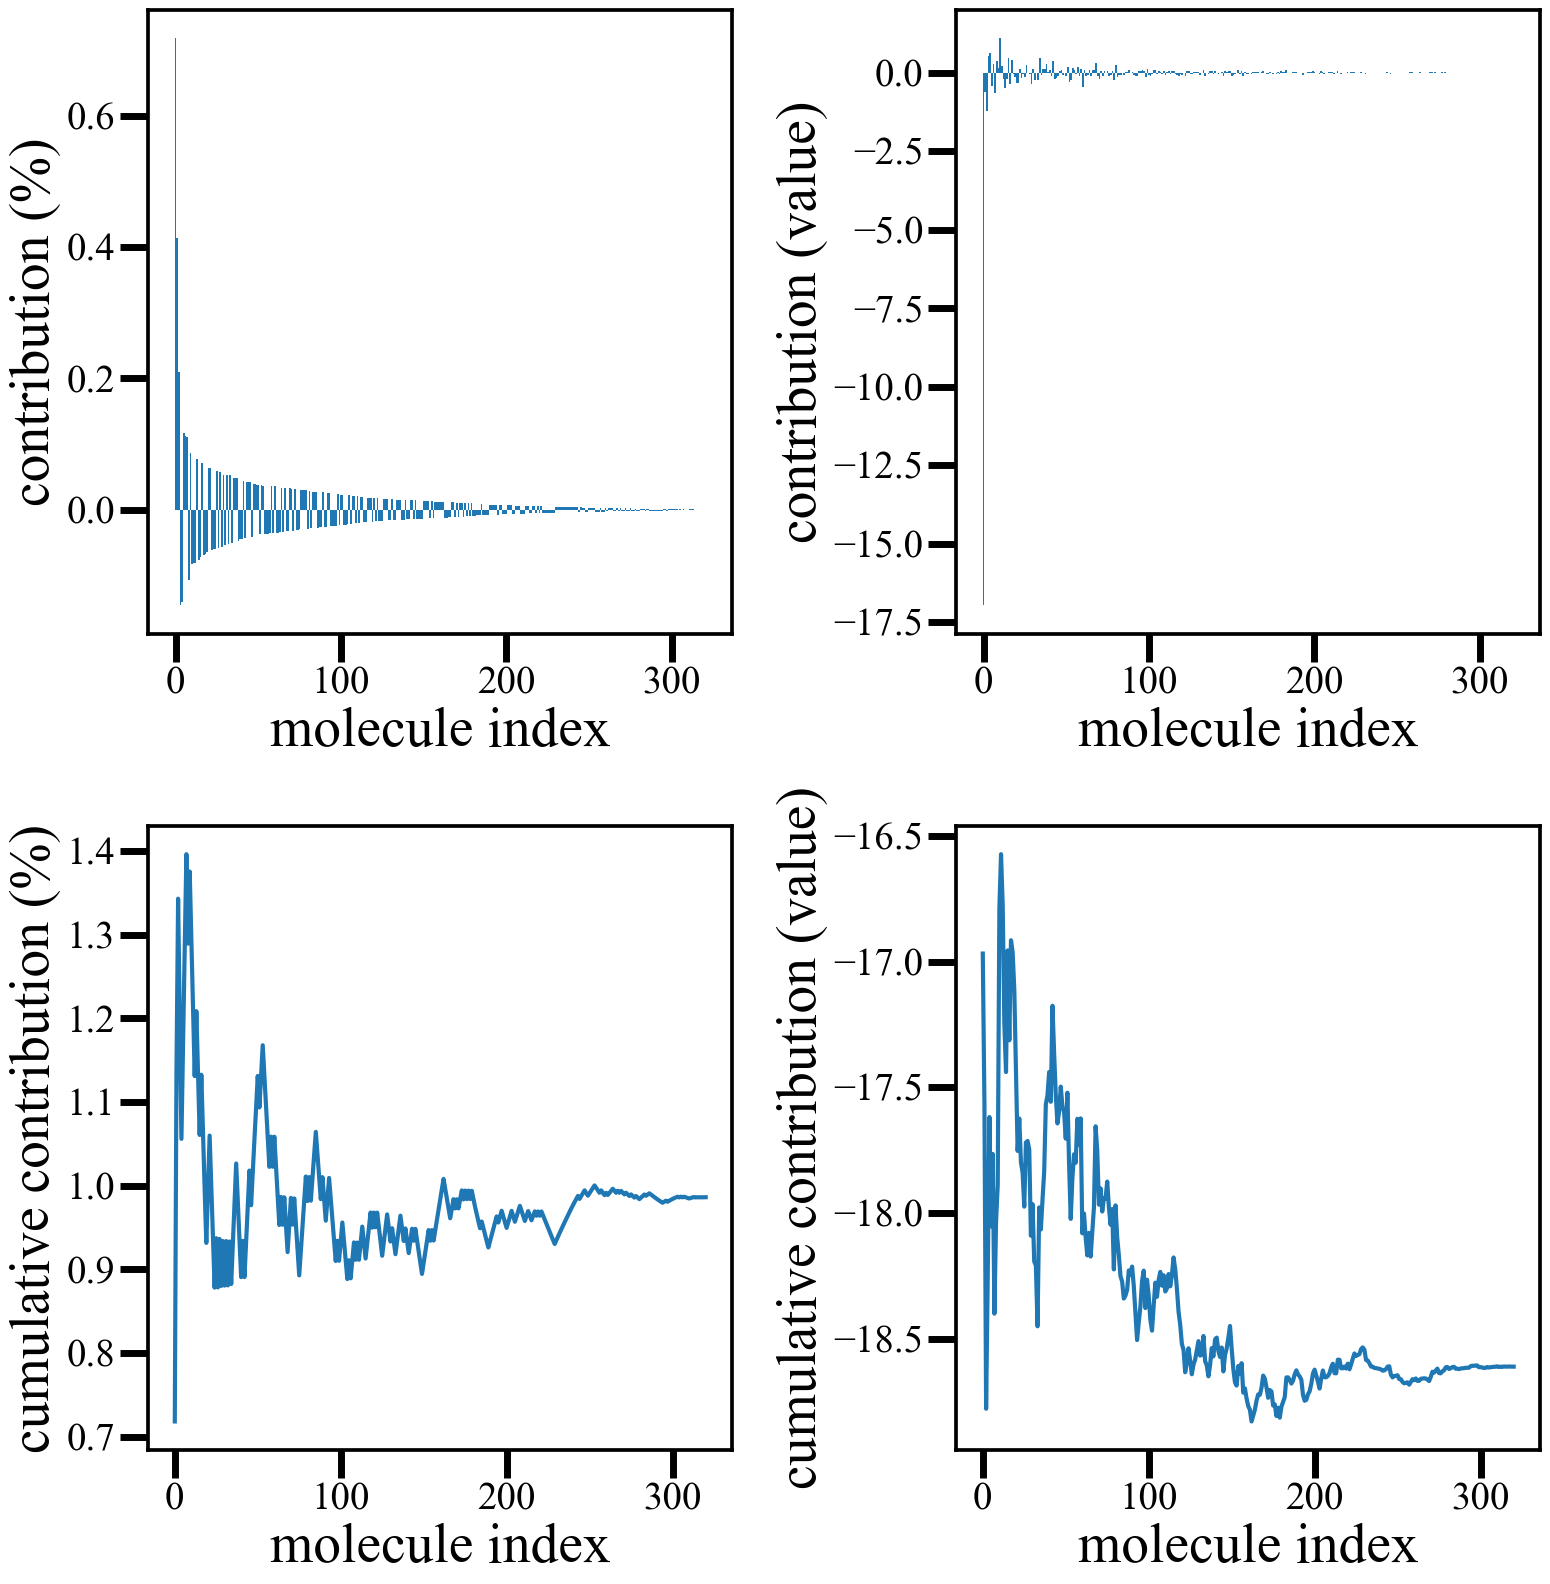

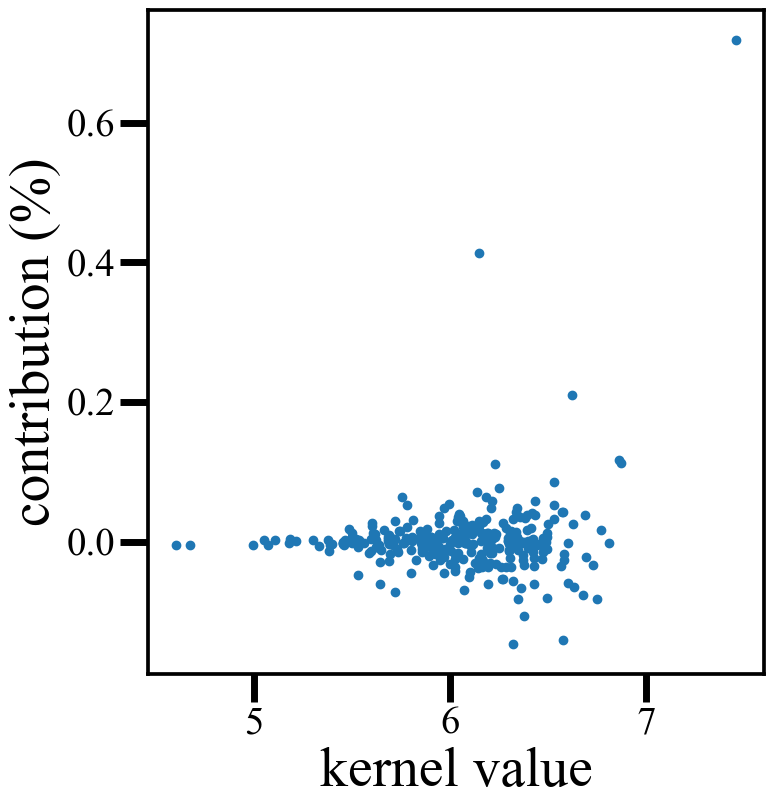

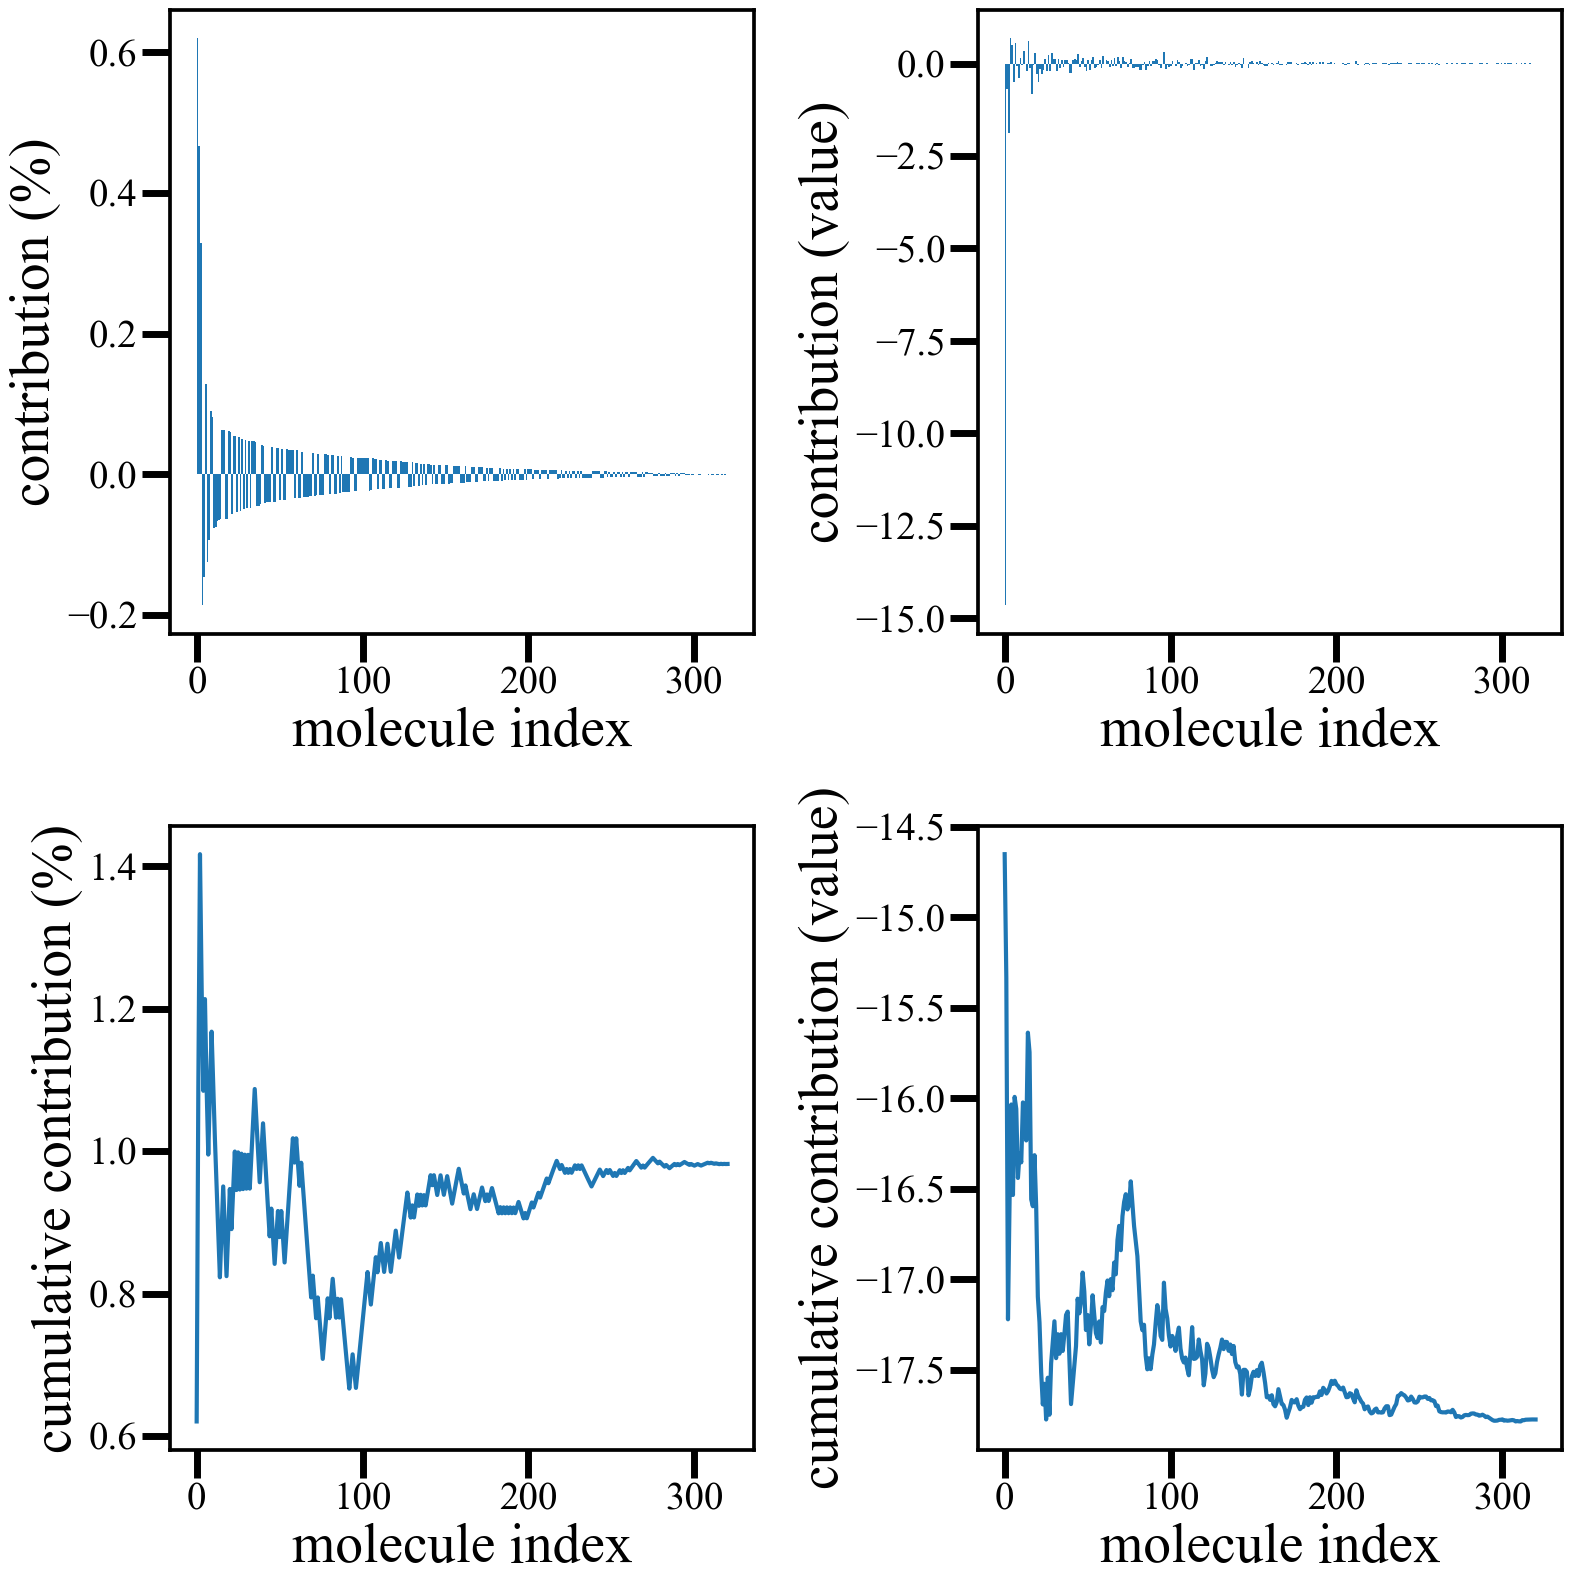

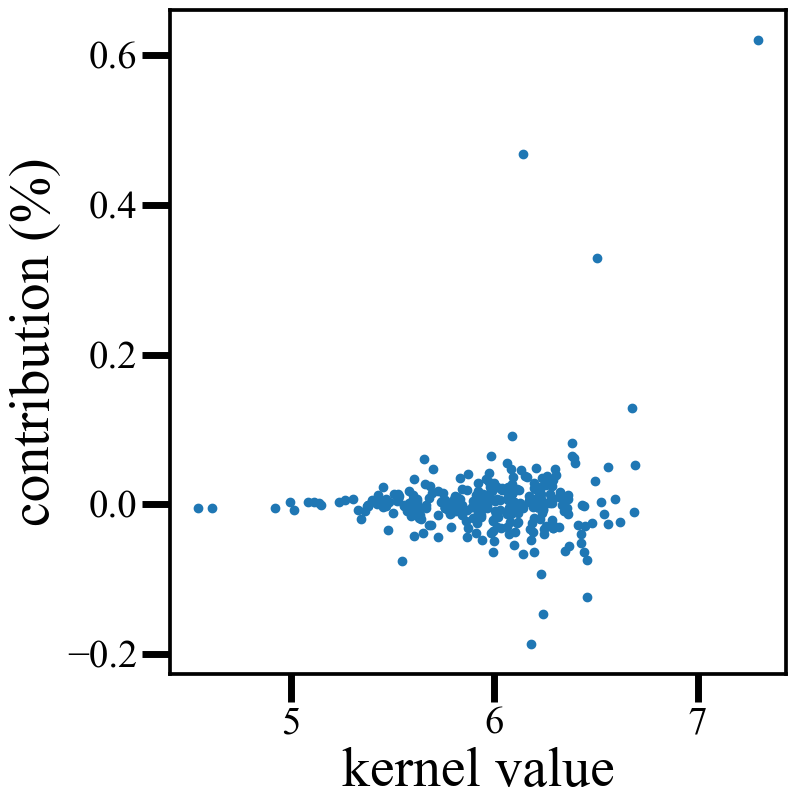

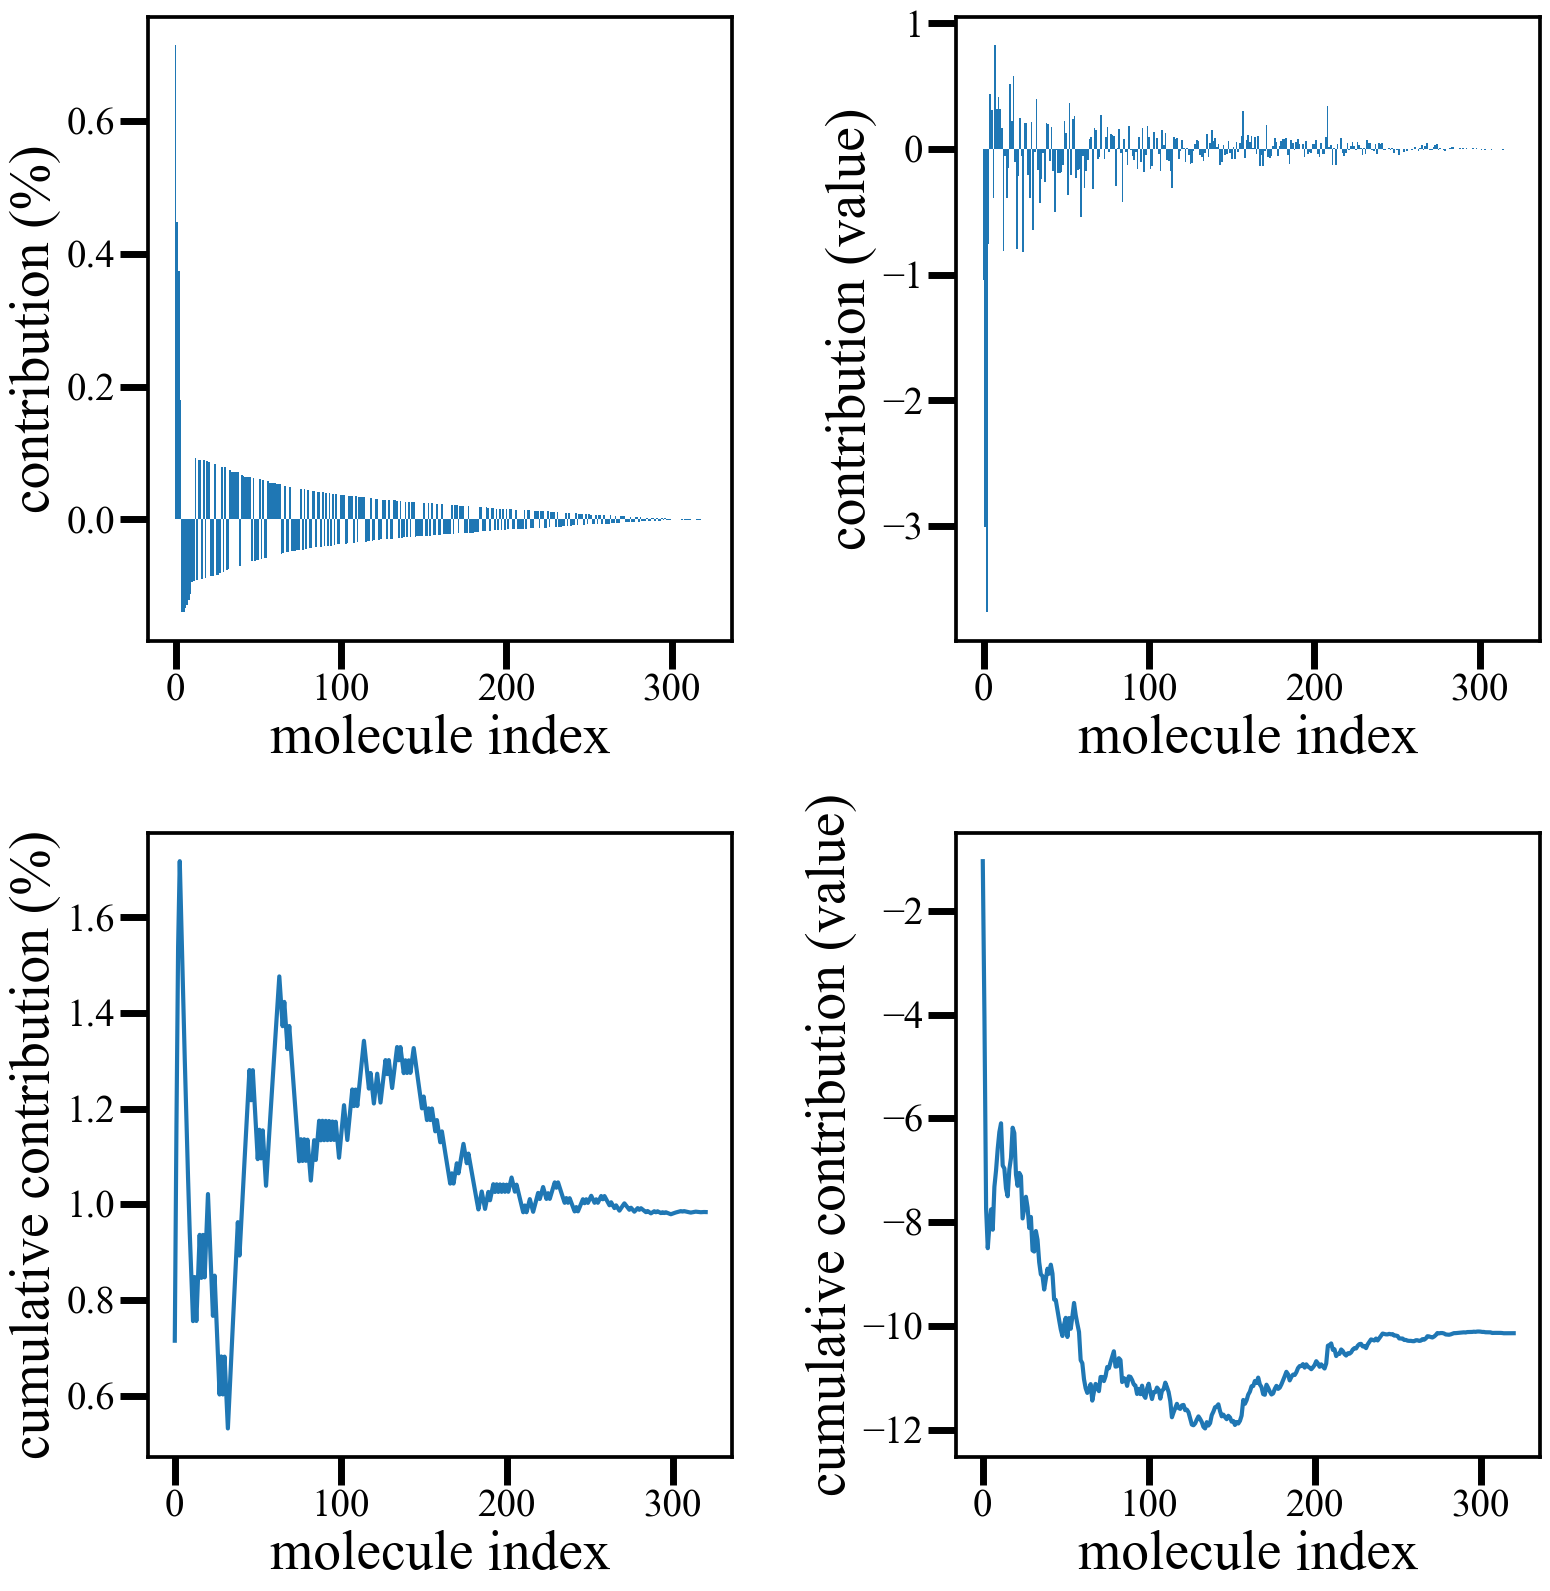

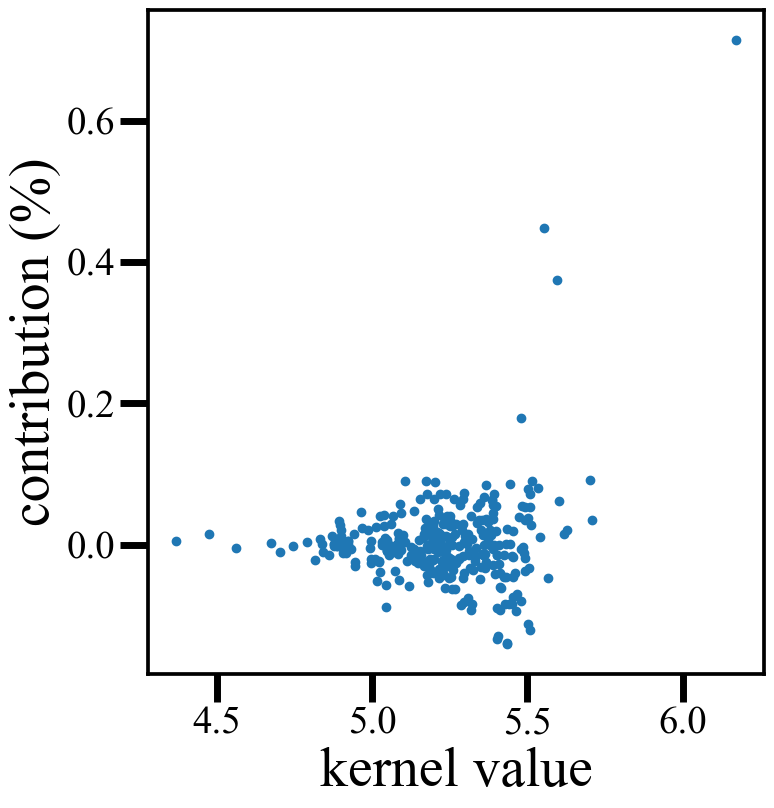

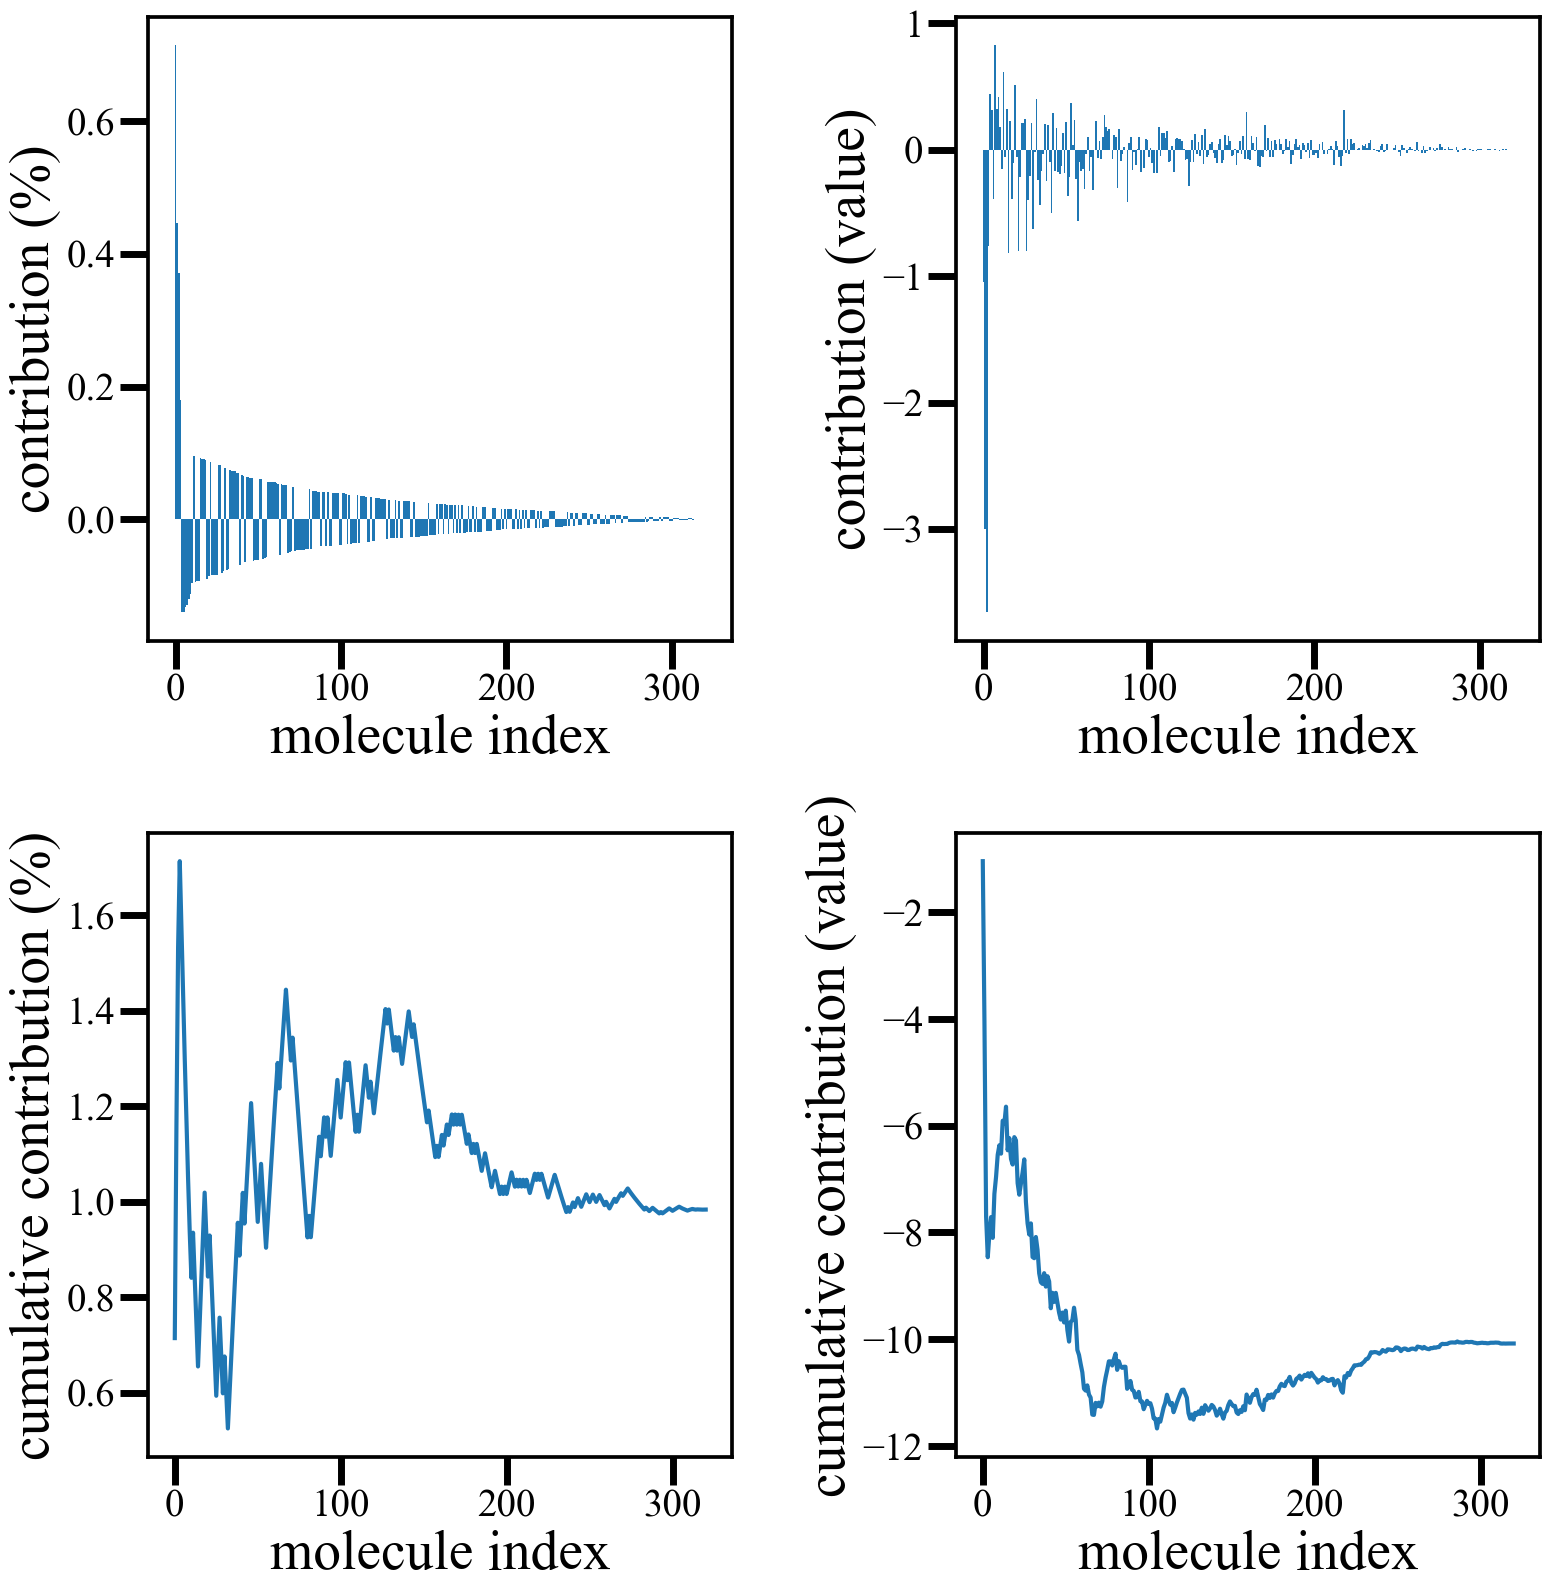

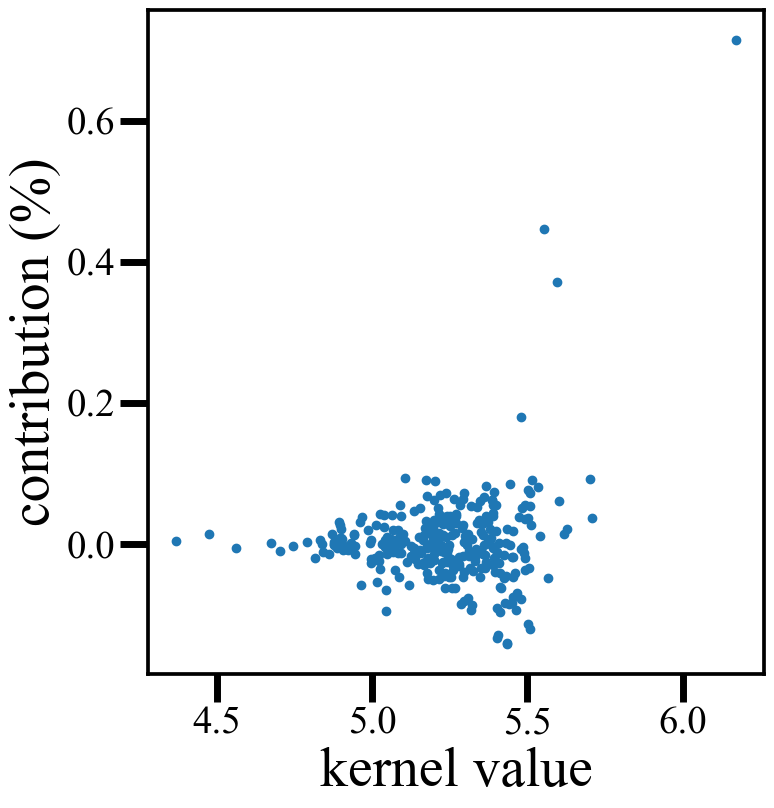

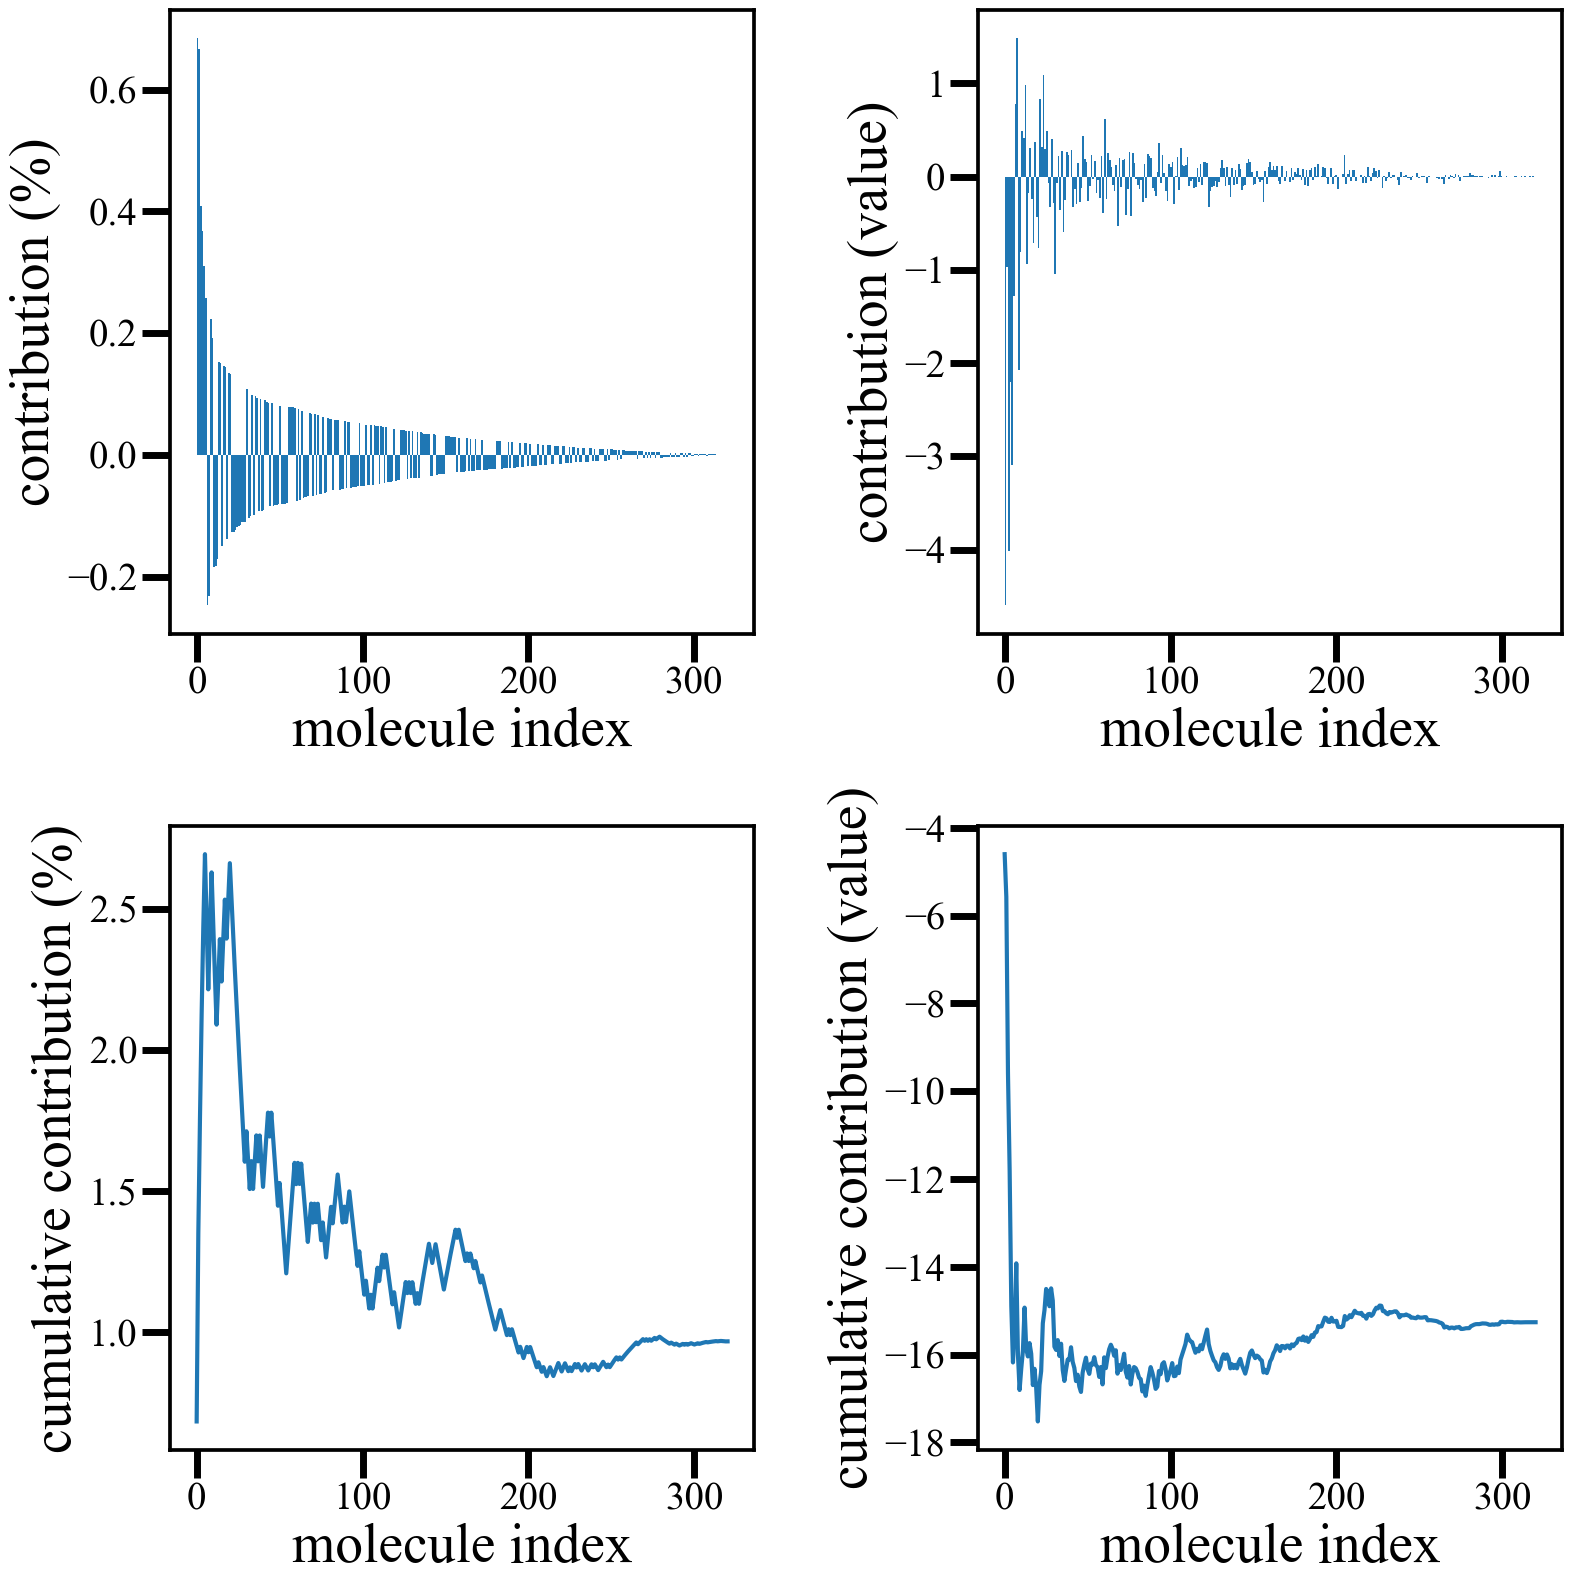

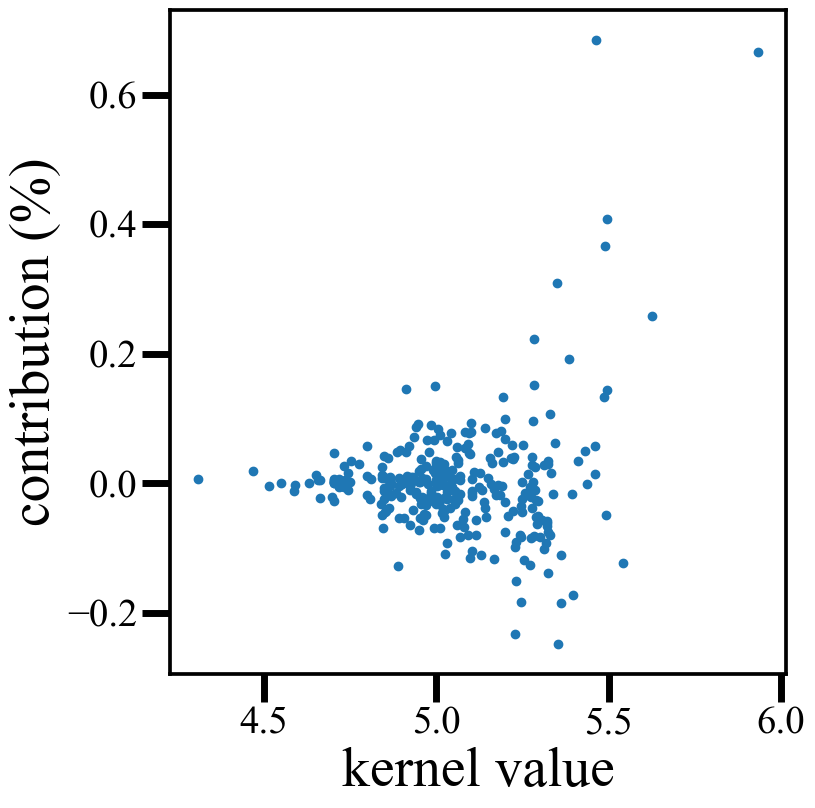

In [14]:
# graph kernel
df_mgk = []
for i, smiles_to_be_interpret in enumerate(smiles_list):
    mol_i = Chem.MolFromSmiles(smiles_to_be_interpret)
    y_pred, y_std, df_interpret= interpret_training_mols(
        smiles_to_be_interpret, 
        smiles_train, 
        targets_train, 
        alpha=alpha, 
        n_mol=n_mol, 
        output_order='sort_by_percentage_contribution', 
        mgk_hyperparameters_file='hyperopt-graph/hyperparameters_0.json',
        n_jobs=1, return_kernel=True)
    df_interpret = df_interpret[0]

    p = stats.zscore(df_interpret['contribution_percentage'].tolist())[0]
    print('Z-score of the most important molecule is: ', p)
    
    df_mgk.append(df_interpret)
    df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
    df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
        x.contribution_value / x.contribution_percentage, 
        x.contribution_percentage, 
        x.contribution_value), axis=1)
    img=Draw.MolsToGridImage(df_interpret.mol.tolist(),molsPerRow=4,
                             subImgSize=(200,200),
                             legends=df_interpret.tag.tolist(),
                             maxMols=12, useSVG=True)
    with open('mgk_top12_%d.svg' % i, "w") as f:
        f.write(img.data)
    
    fs = 8
    params = {'legend.fontsize': '%s' % (3.5 * fs),
              'figure.figsize': (fs * 2, fs * 2),  # 8*6
              'axes.labelsize': '%s' % (5 * fs),
              'axes.titlesize': '%s' % (5 * fs),
              'xtick.labelsize': '%s' % (3.5 * fs),
              'ytick.labelsize': '%s' % (3.5 * fs),
              'font.family': 'serif',
              'font.serif': 'Times New Roman',
              'axes.linewidth': fs / 3,
              }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.11, 0.14, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.08, 0.12, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)

    nx = 1
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_percentage, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (%)')


    nx = 2
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_value, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (value)')

    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_percentage)
    ax.plot(df_interpret.index, accumulate_sum, linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (%)')

    nx = 2
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_value)
    ax.plot(df_interpret.index, accumulate_sum,  linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (value)')
    
    plt.savefig('mgk_spectrum_%d.png' % i)
    
    params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.21, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.15, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)
    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)       
    ax.scatter(df_interpret['kernel'], df_interpret['contribution_percentage'])                                    
    ax.set_xlabel('kernel value')
    ax.set_ylabel('contribution (%)')
    
    plt.savefig('mgk_contribution_vs_kernel_%d.png' % i)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.9s finished


Z-score of the most important molecule is:  8.936063100462933
percentage for the most important molecule of GPR-MGK 0.02315278407274574
Z-score of the most important molecule of GPR-MGK is:  0.5460993104488461


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.6s finished


Z-score of the most important molecule is:  9.646768505041264
percentage for the most important molecule of GPR-MGK -0.004667452860231086
Z-score of the most important molecule of GPR-MGK is:  -0.3144041606148963


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


Z-score of the most important molecule is:  5.923261777713707
percentage for the most important molecule of GPR-MGK 0.1037020999703913
Z-score of the most important molecule of GPR-MGK is:  2.4276729864866935


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.4s finished


Z-score of the most important molecule is:  6.176594554606004
percentage for the most important molecule of GPR-MGK 0.09697645379033536
Z-score of the most important molecule of GPR-MGK is:  2.464703336447514


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s finished


Z-score of the most important molecule is:  7.364277051973815
percentage for the most important molecule of GPR-MGK 0.0018093103698032266
Z-score of the most important molecule of GPR-MGK is:  -0.04979511117196214


/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(


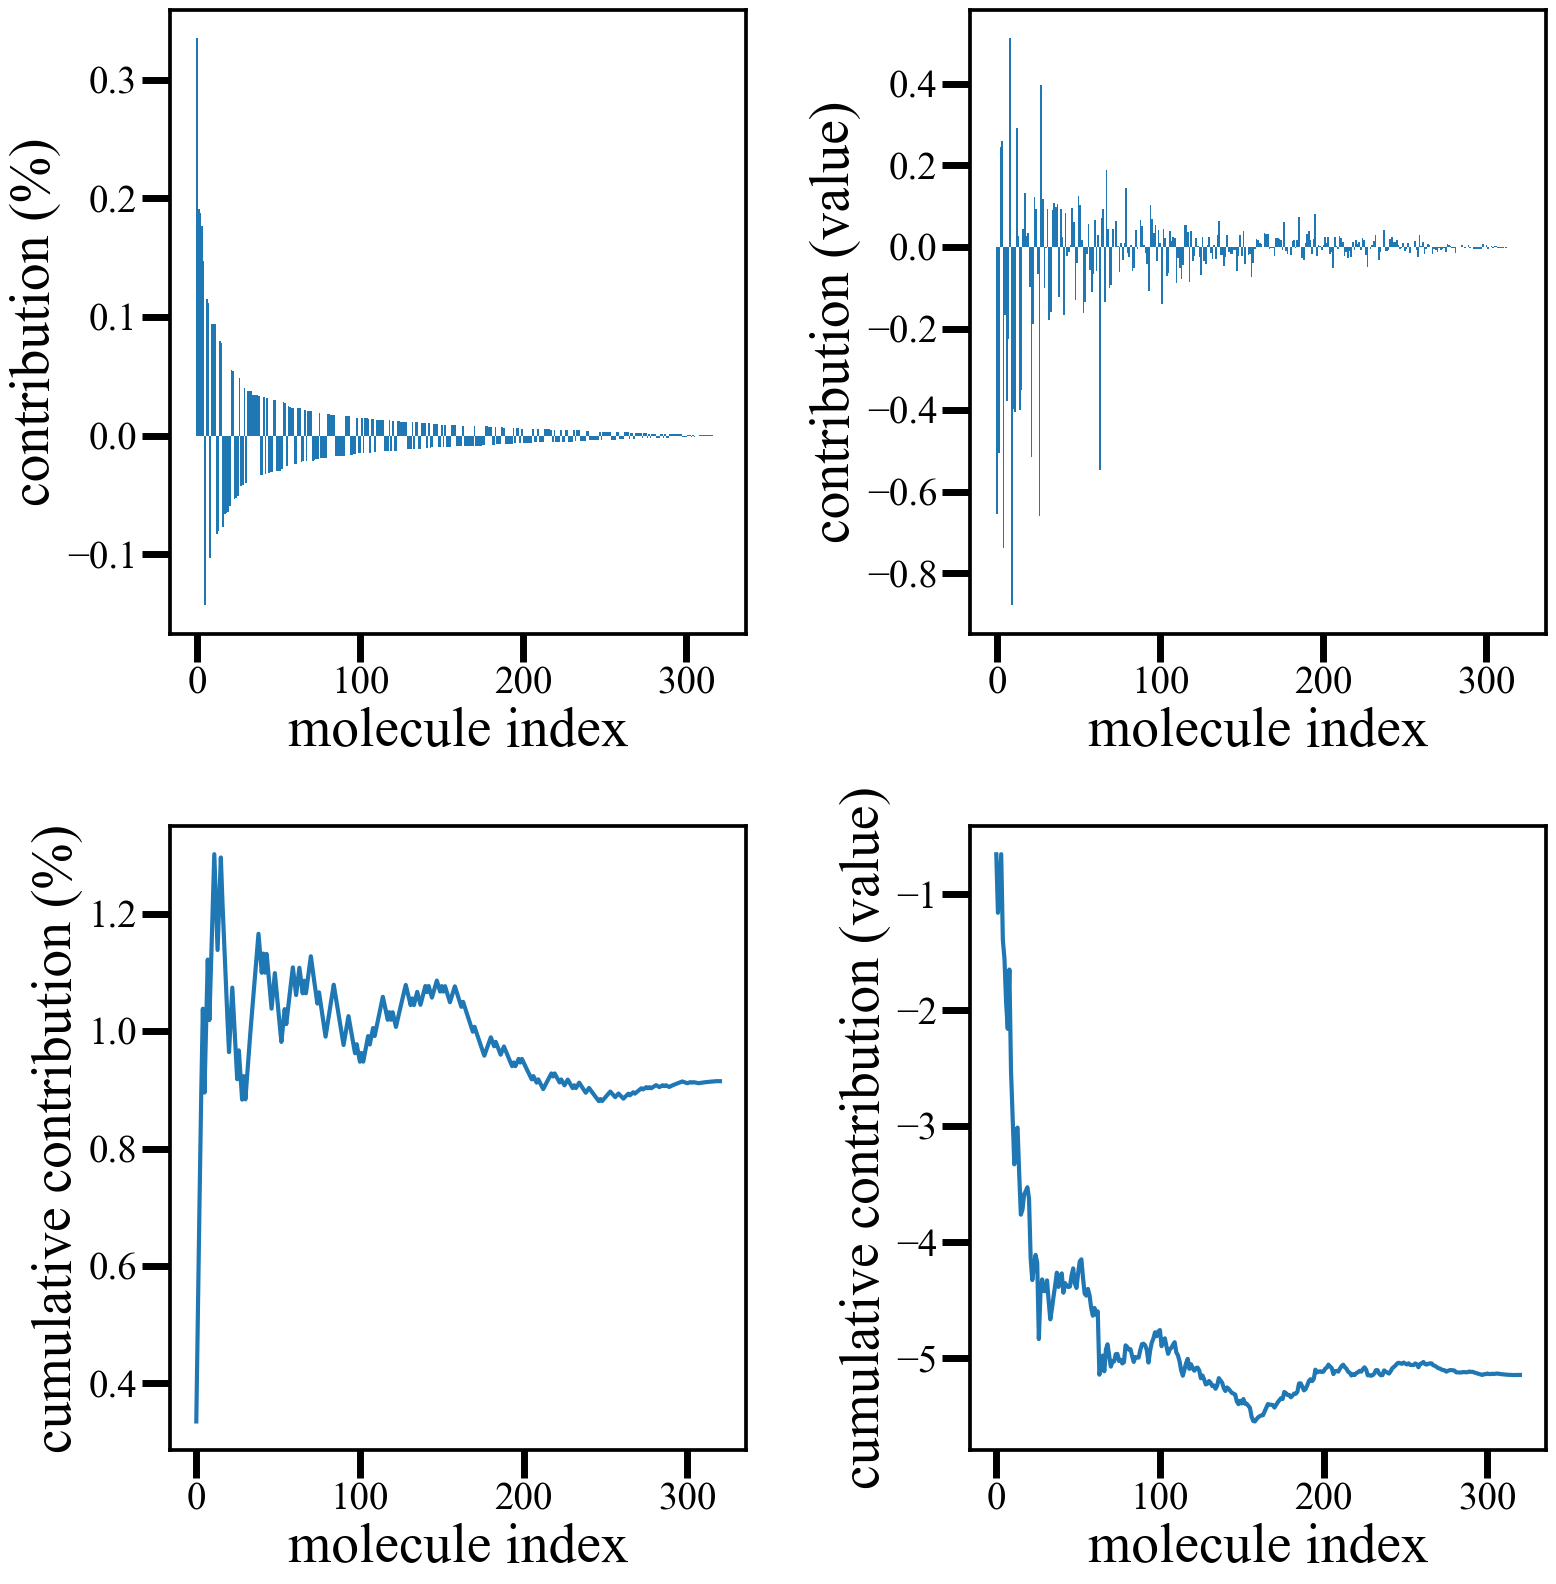

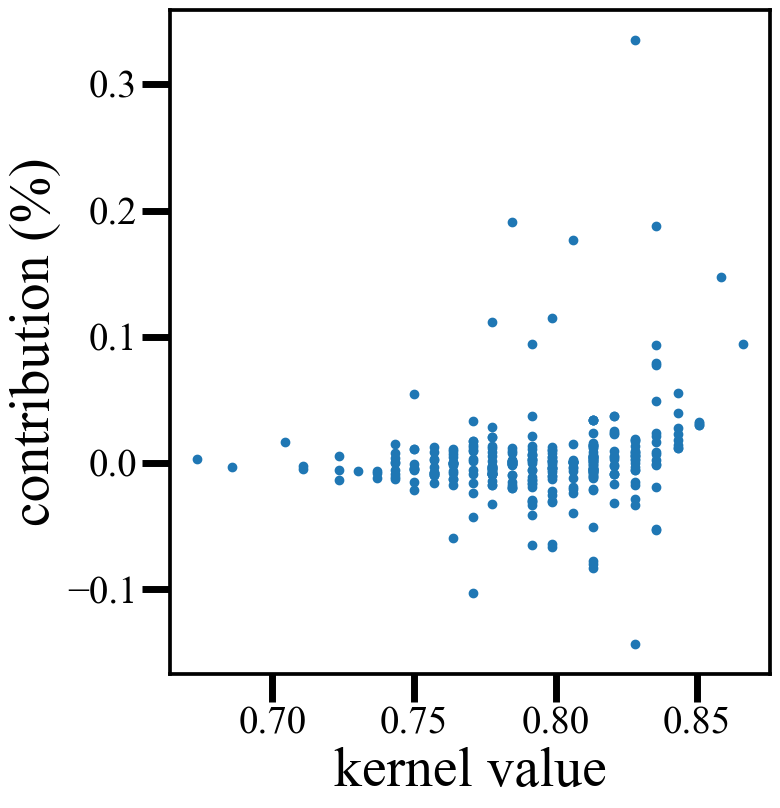

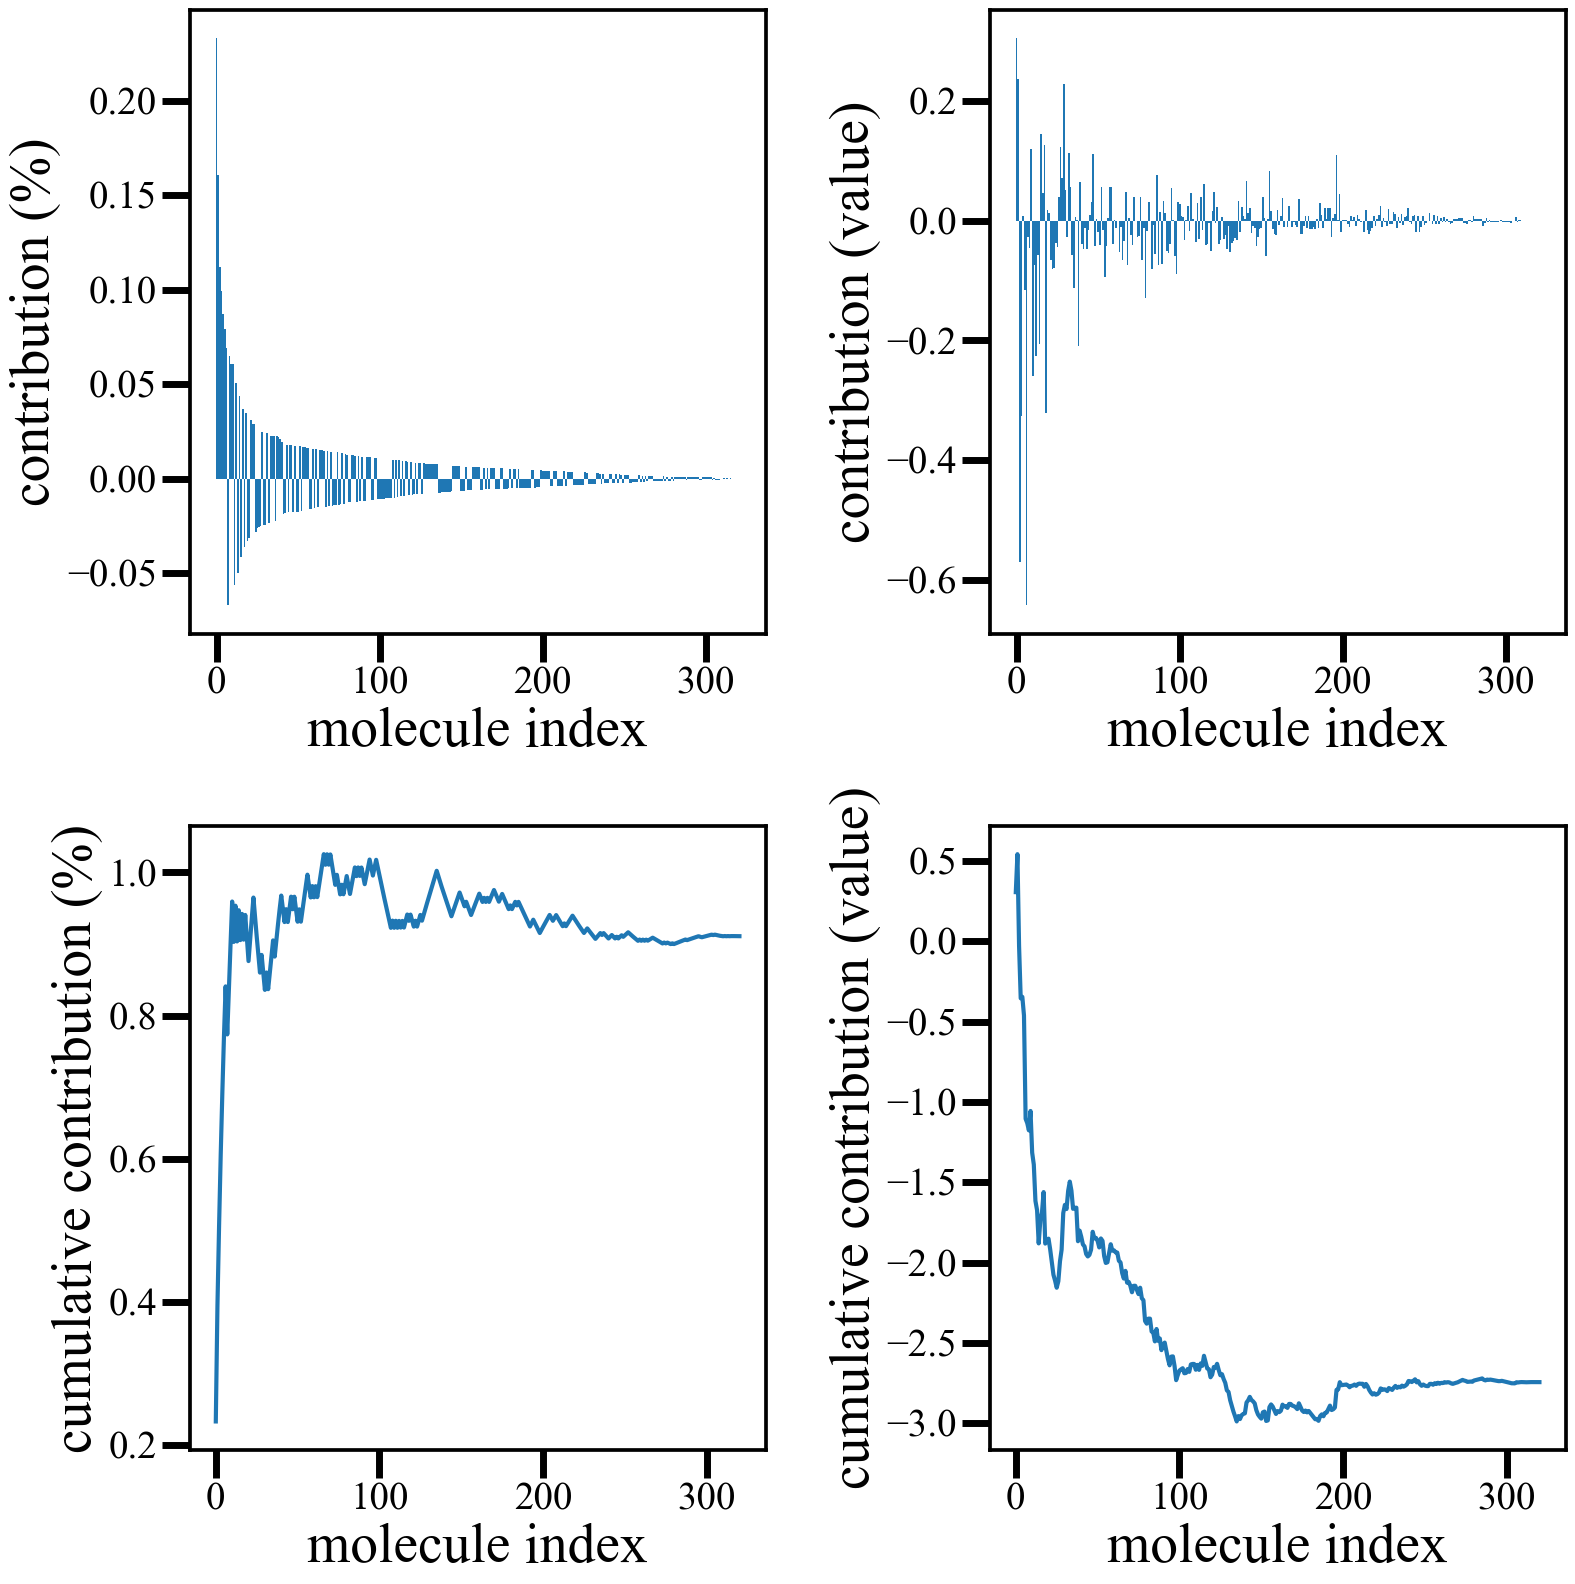

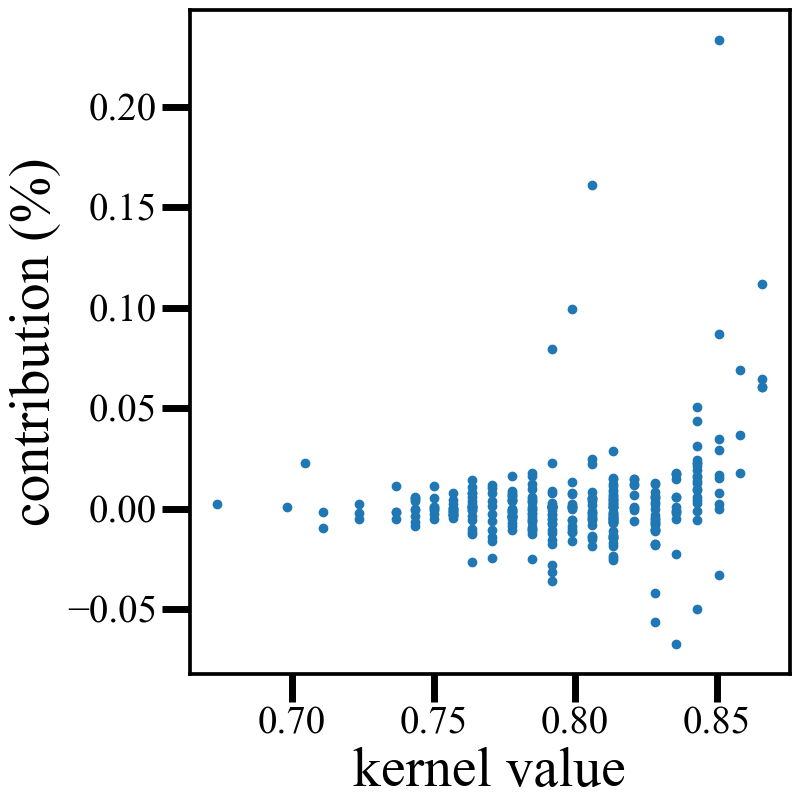

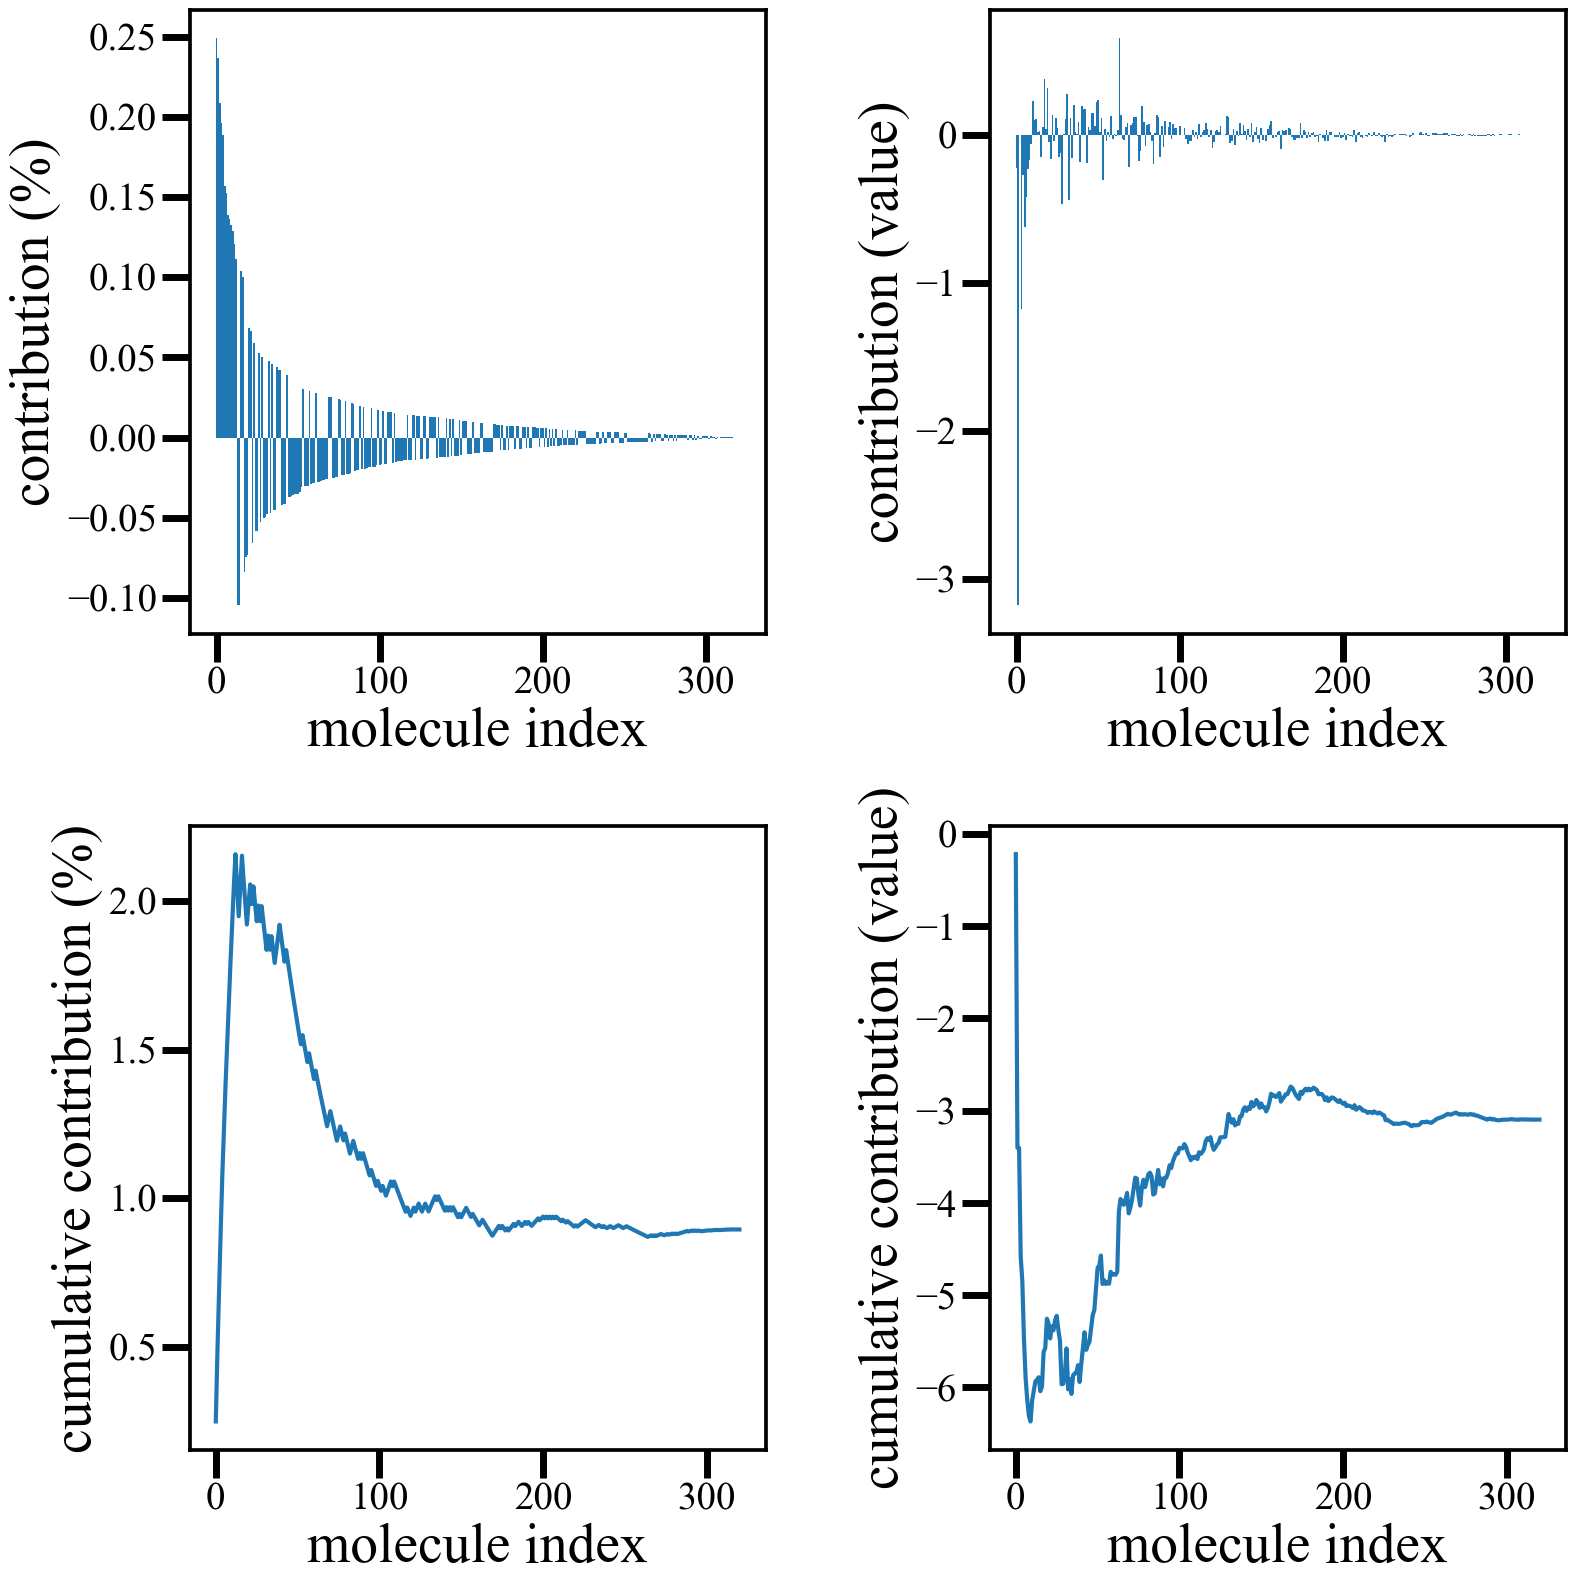

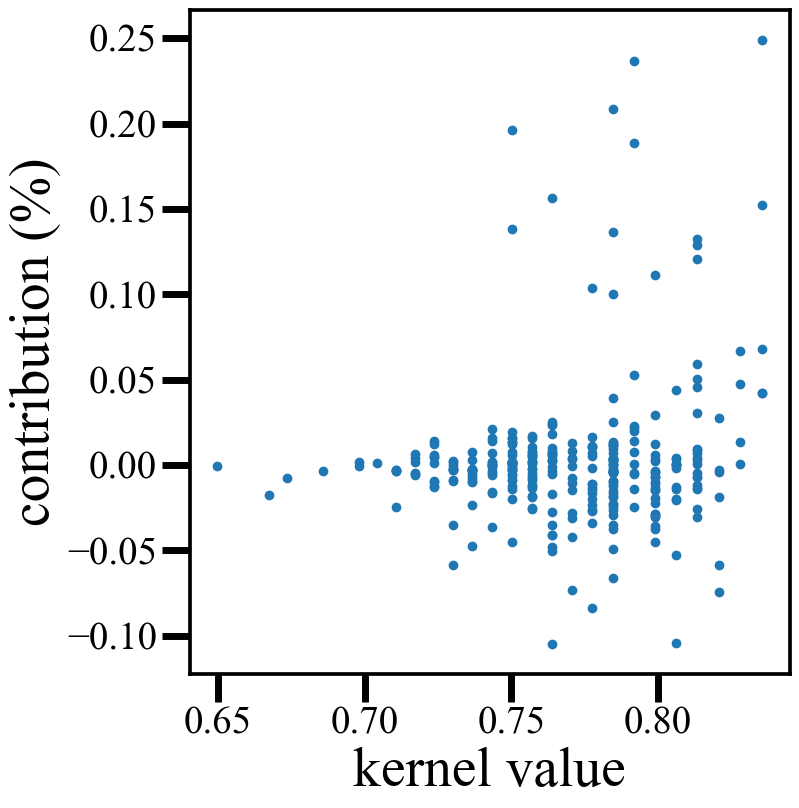

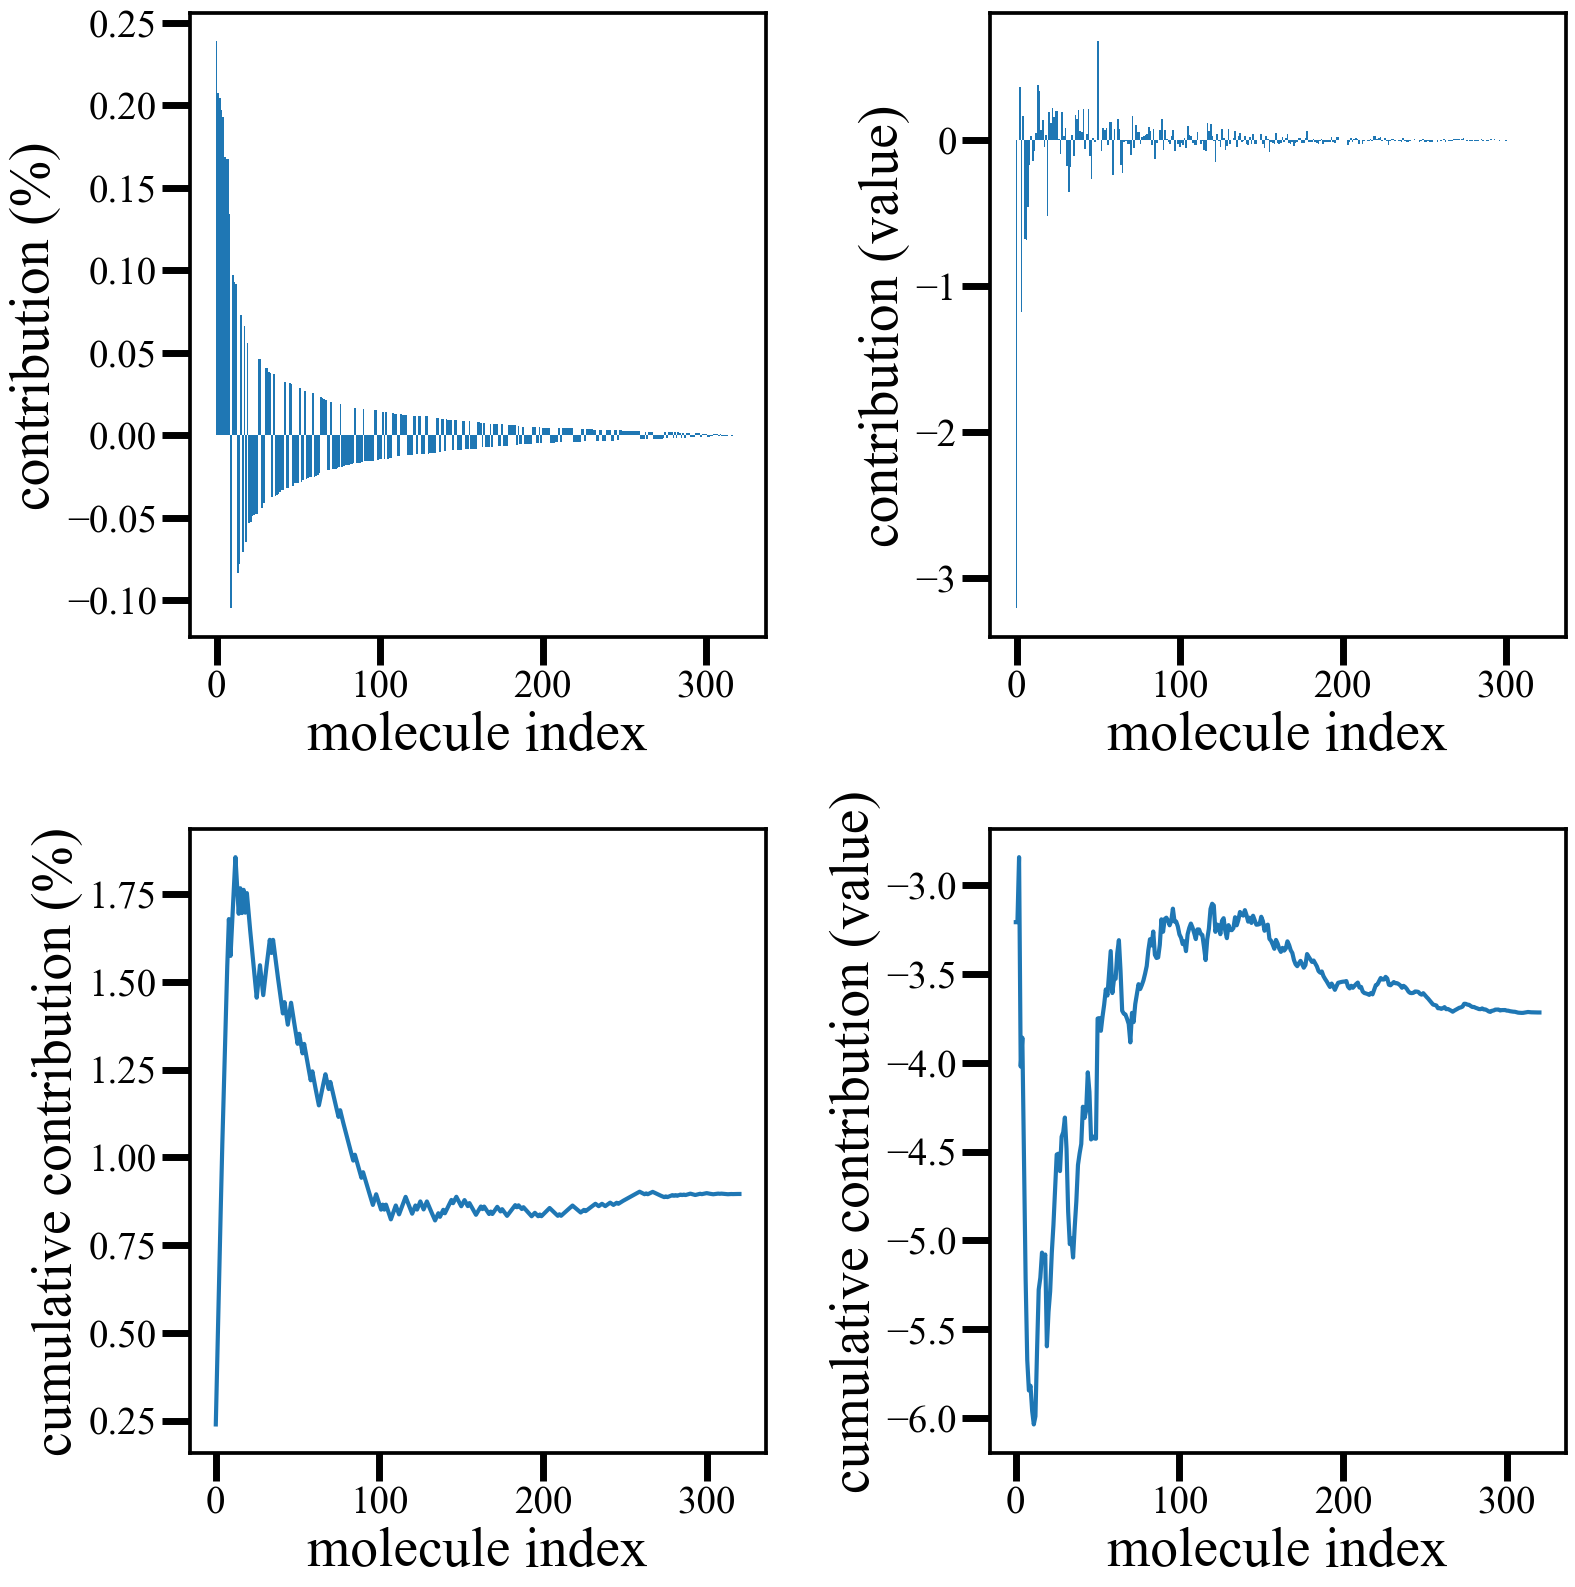

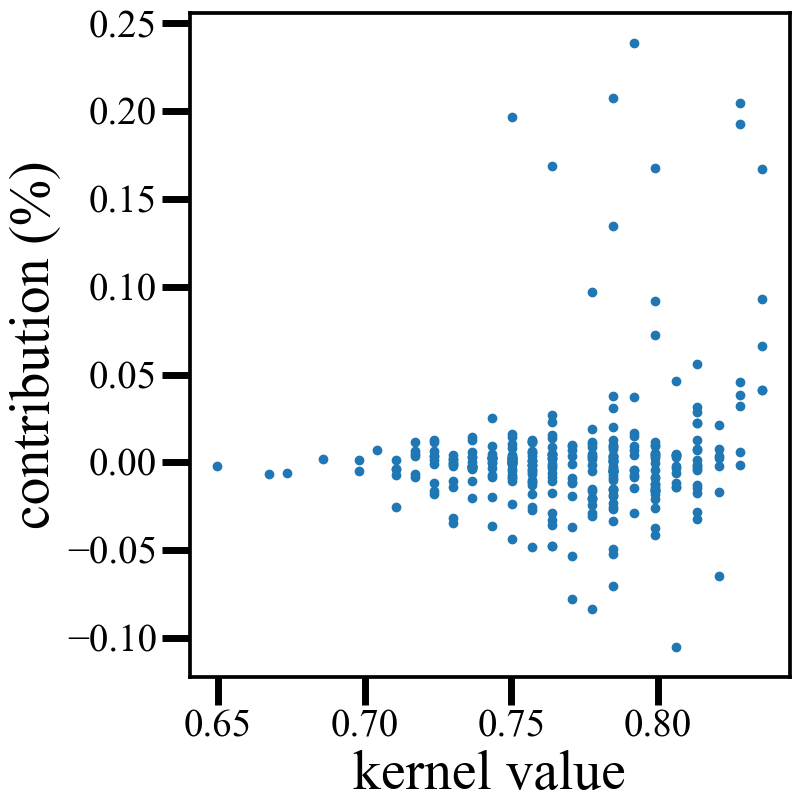

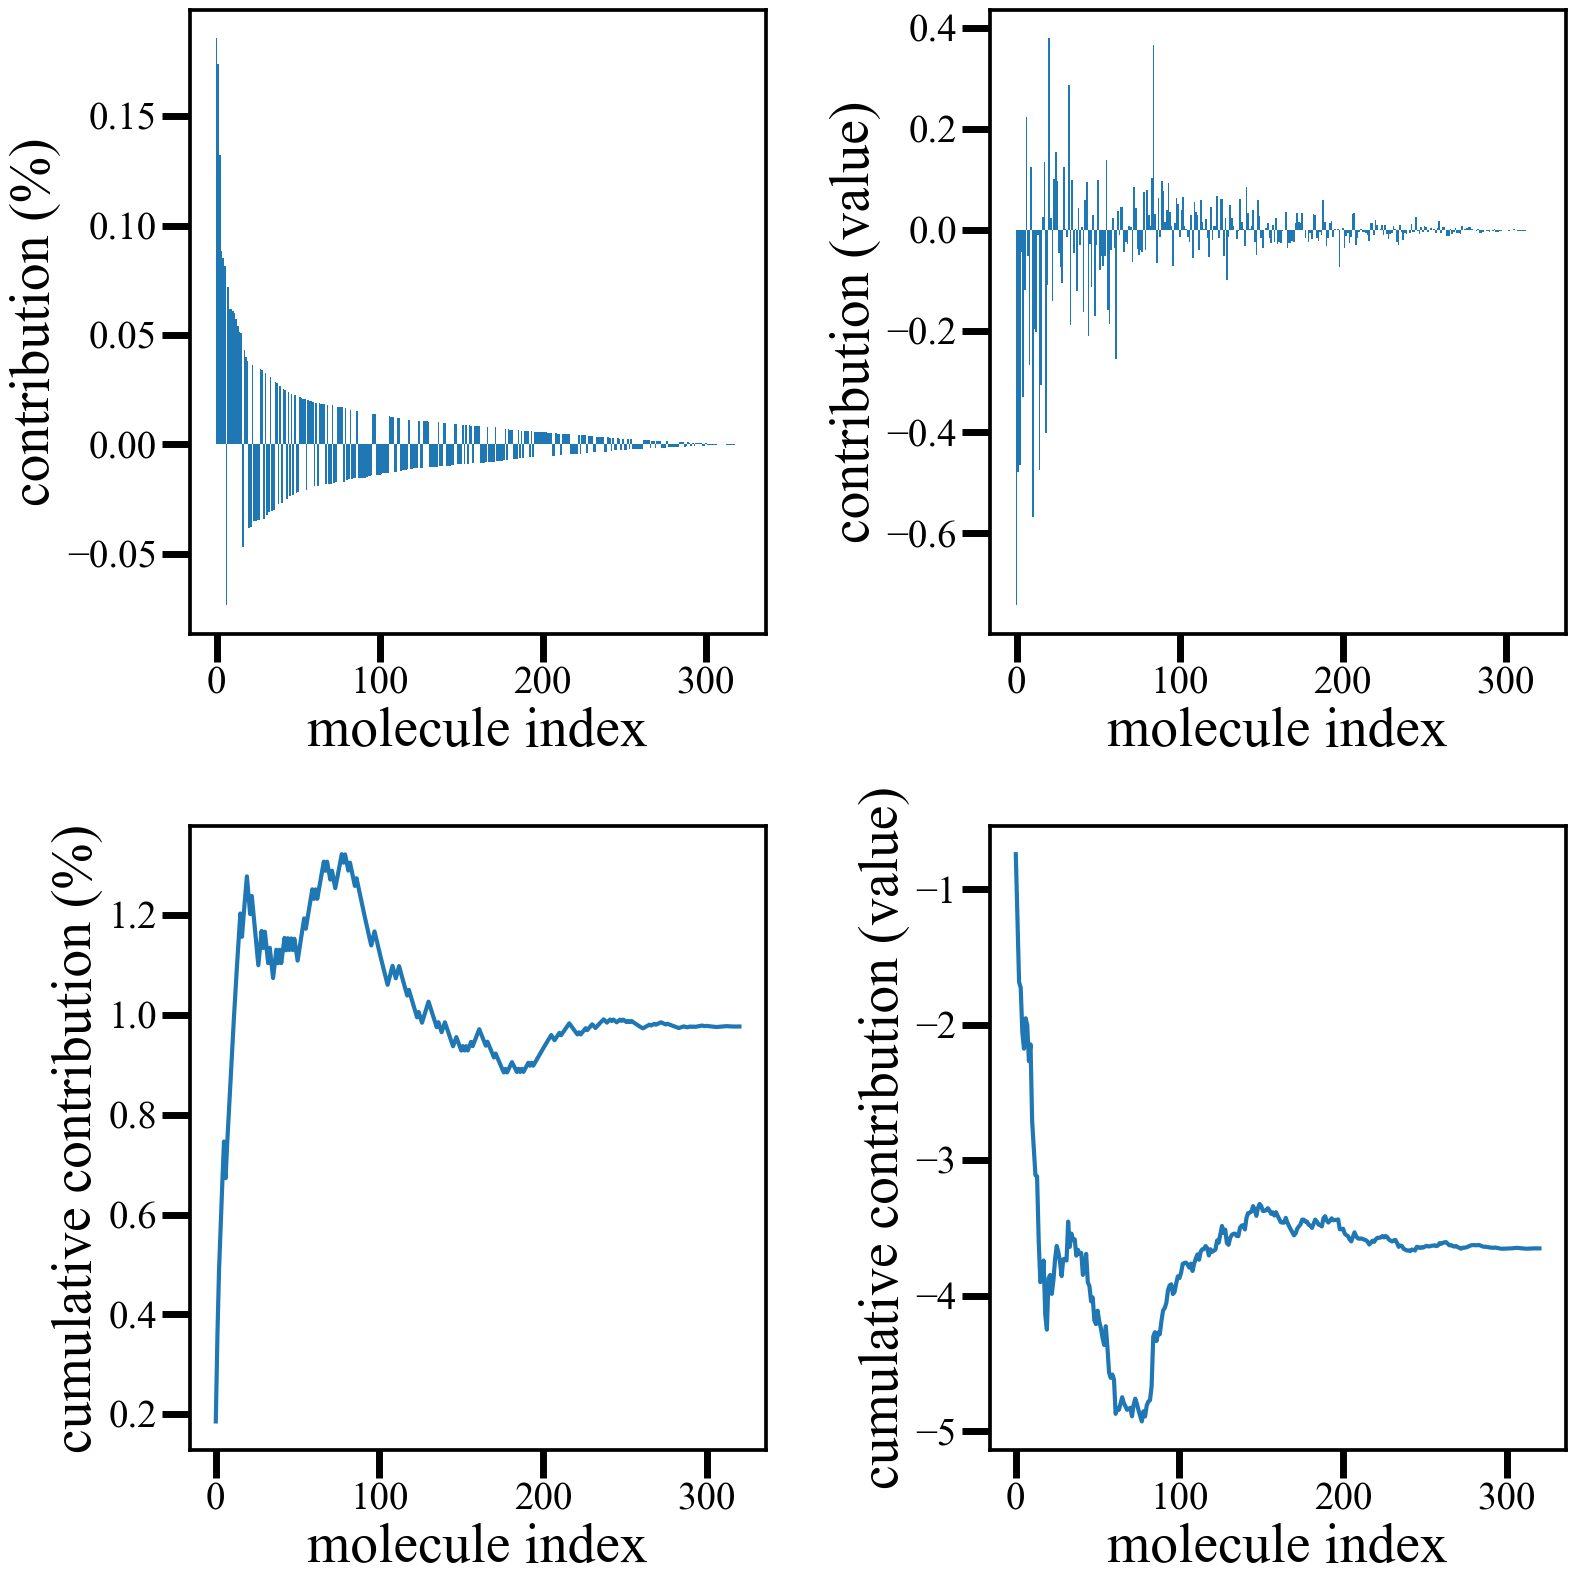

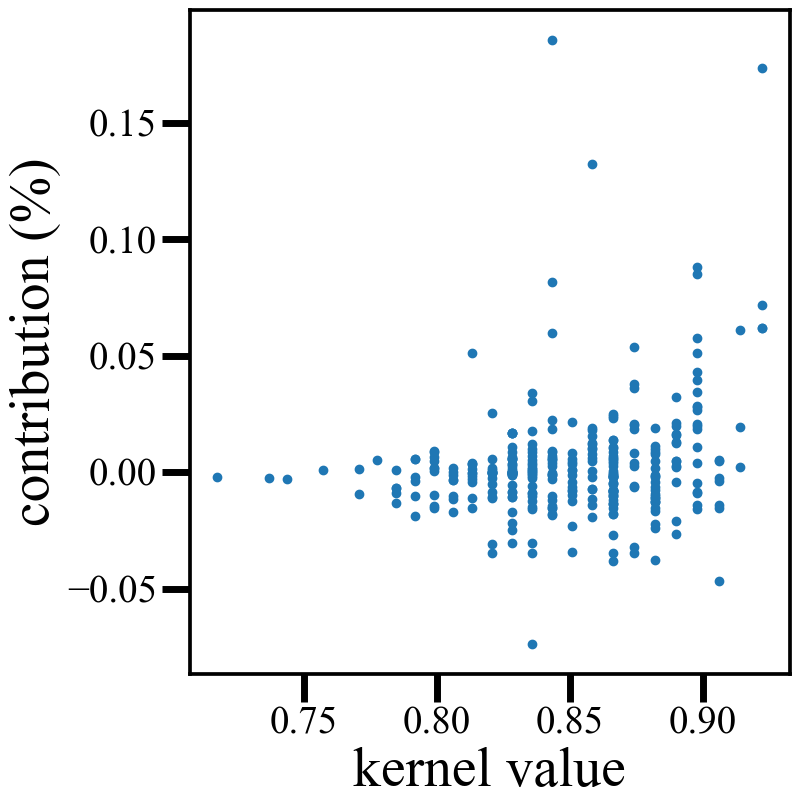

In [15]:
# GPR-RBF-Morgan 
df_morgan = []
for i, smiles_to_be_interpret in enumerate(smiles_list):
    mol_i = Chem.MolFromSmiles(smiles_to_be_interpret)
    y_pred, y_std, df_interpret= interpret_training_mols(
        smiles_to_be_interpret, 
        smiles_train, 
        targets_train, 
        alpha=alpha, 
        n_mol=n_mol, 
        output_order='sort_by_percentage_contribution', 
        mgk_hyperparameters_file=None,
        features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json',
        features_generator = ['morgan'],
        n_jobs=1, return_kernel=True)
    df_interpret = df_interpret[0]
    
    p = stats.zscore(df_interpret['contribution_percentage'].tolist())[0]
    print('Z-score of the most important molecule is: ', p)
    idx = df_interpret['smiles_train'].tolist().index(df_mgk[i]['smiles_train'][0])
    print('percentage for the most important molecule of GPR-MGK', df_interpret['contribution_percentage'].tolist()[idx])
    p = stats.zscore(df_interpret['contribution_percentage'].tolist())[idx]
    print('Z-score of the most important molecule of GPR-MGK is: ', p)
    df_morgan.append(df_interpret)
    df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
    df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
        x.contribution_value / x.contribution_percentage, 
        x.contribution_percentage, 
        x.contribution_value), axis=1)
    img=Draw.MolsToGridImage(df_interpret.mol.tolist(),molsPerRow=4,
                             subImgSize=(200,200),
                             legends=df_interpret.tag.tolist(),
                             maxMols=12, useSVG=True)
    with open('morgan_top12_%d.svg' % i, "w") as f:
        f.write(img.data)
    
    fs = 8
    params = {'legend.fontsize': '%s' % (3.5 * fs),
              'figure.figsize': (fs * 2, fs * 2),  # 8*6
              'axes.labelsize': '%s' % (5 * fs),
              'axes.titlesize': '%s' % (5 * fs),
              'xtick.labelsize': '%s' % (3.5 * fs),
              'ytick.labelsize': '%s' % (3.5 * fs),
              'font.family': 'serif',
              'font.serif': 'Times New Roman',
              'axes.linewidth': fs / 3,
              }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.12, 0.14, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.08, 0.12, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)

    nx = 1
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_percentage, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (%)')


    nx = 2
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_value, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (value)')

    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_percentage)
    ax.plot(df_interpret.index, accumulate_sum, linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (%)')

    nx = 2
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_value)
    ax.plot(df_interpret.index, accumulate_sum,  linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (value)')
    
    plt.savefig('morgan_spectrum_%d.png' % i)
    
    params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()
                                             
    dxs = [0.23, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.15, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)
    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)       
    ax.scatter(df_interpret['kernel'], df_interpret['contribution_percentage'])                                    
    ax.set_xlabel('kernel value')
    ax.set_ylabel('contribution (%)')
    
    plt.savefig('morgan_contribution_vs_kernel_%d.png' % i)

In [16]:
for i in range(5):
    print('For molecule %s' % smiles_list[i])
    smiles = df_mgk[i].smiles_train[0]
    print('molecule with the highest contribution in GPR-MGK is %s' % smiles)
    display(df_mgk[i][df_mgk[i].smiles_train == smiles])
    display(df_morgan[i][df_morgan[i].smiles_train == smiles])

For molecule C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O
molecule with the highest contribution in GPR-MGK is C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


smiles_train  contribution_percentage  \
0  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.718379   

   contribution_value    kernel  \
0          -16.968111  7.460976   

                                                mol                   tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7f5f658177d0>  -23.62 X 0.72=-16.97

smiles_train  contribution_percentage  \
63  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.023153   

    contribution_value    kernel  \
63           -0.546869  0.820657   

                                                 mol                  tag  
63  <rdkit.Chem.rdchem.Mol object at 0x7f5e6843fa70>  -23.62 X 0.02=-0.55

For molecule C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O
molecule with the highest contribution in GPR-MGK is C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


smiles_train  contribution_percentage  \
0  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.620277   

   contribution_value    kernel  \
0          -14.650933  7.297049   

                                                mol                   tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7f5e547f2ff0>  -23.62 X 0.62=-14.65

smiles_train  contribution_percentage  \
196  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                -0.004667   

     contribution_value    kernel  \
196            0.110245  0.806042   

                                                  mol                  tag  
196  <rdkit.Chem.rdchem.Mol object at 0x7f5eb2a01cb0>  -23.62 X -0.00=0.11

For molecule c1c(c(=O)[nH]c(=O)[nH]1)I
molecule with the highest contribution in GPR-MGK is c1ccc2c(c1)CCC2


smiles_train  contribution_percentage  contribution_value    kernel  \
0  c1ccc2c(c1)CCC2                 0.714706           -1.043471  6.172775   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7f5e45549ee0>  -1.46 X 0.71=-1.04

smiles_train  contribution_percentage  contribution_value   kernel  \
15  c1ccc2c(c1)CCC2                 0.103702           -0.151405  0.77759   

                                                 mol                 tag  
15  <rdkit.Chem.rdchem.Mol object at 0x7f5e690ac9e0>  -1.46 X 0.10=-0.15

For molecule c1c(c(=O)[nH]c(=O)[nH]1)Br
molecule with the highest contribution in GPR-MGK is c1ccc2c(c1)CCC2


smiles_train  contribution_percentage  contribution_value    kernel  \
0  c1ccc2c(c1)CCC2                 0.714727           -1.043501  6.172775   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7f5e6843c740>  -1.46 X 0.71=-1.04

smiles_train  contribution_percentage  contribution_value   kernel  \
10  c1ccc2c(c1)CCC2                 0.096976           -0.141586  0.77759   

                                                 mol                 tag  
10  <rdkit.Chem.rdchem.Mol object at 0x7f5f64f87d80>  -1.46 X 0.10=-0.14

For molecule c1(=O)[nH]c(=O)[nH]c(=O)[nH]1
molecule with the highest contribution in GPR-MGK is COC(=O)CC#N


smiles_train  contribution_percentage  contribution_value    kernel  \
0  COC(=O)CC#N                 0.684474           -4.599664  5.462559   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7f5f64d6a5e0>  -6.72 X 0.68=-4.60

smiles_train  contribution_percentage  contribution_value    kernel  \
265  COC(=O)CC#N                 0.001809           -0.012159  0.820657   

                                                  mol                 tag  
265  <rdkit.Chem.rdchem.Mol object at 0x7f5e542c94d0>  -6.72 X 0.00=-0.01

In [17]:
fg = FeaturesGenerator('morgan')
def compare_fp(s1, s2):
    a = fg(s1)
    b = fg(s2)
    return np.logical_or(a, b).sum(), np.logical_and(a, b).sum()
print(compare_fp('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O', 'C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O'))
print(compare_fp('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O', 'C(CBr)Cl'))

(25, 3)
(23, 2)


{80: ((0, 0),), 158: ((4, 2),), 222: ((11, 1),), 432: ((6, 2),), 576: ((5, 1),), 610: ((1, 1),), 656: ((6, 0),), 807: ((7, 0), (8, 0), (9, 0), (10, 0), (11, 0)), 1019: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0)), 1037: ((3, 2),), 1234: ((1, 2),), 1257: ((7, 1), (8, 1), (9, 1), (10, 1)), 1487: ((4, 1), (3, 1), (2, 1)), 1516: ((0, 1),), 1764: ((5, 2), (0, 2)), 1844: ((2, 2),), 1921: ((6, 1),)}


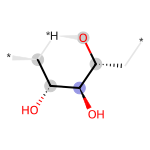

In [18]:
# bit collision
mol = Chem.MolFromSmiles('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O')
bi = {}
fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
print(bi)
Draw.DrawMorganBit(mol, 1844, bi, useSVG=True)

{80: ((0, 0), (1, 0)), 251: ((2, 1),), 495: ((1, 1),), 728: ((2, 0),), 1109: ((3, 1),), 1456: ((0, 1),), 1683: ((3, 0),), 1844: ((0, 2),)}


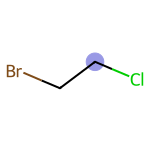

In [19]:
# bit collision
mol = Chem.MolFromSmiles('C(CBr)Cl')
bi = {}
fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
print(bi)
Draw.DrawMorganBit(mol, 1844, bi, useSVG=True)

# Figure 3

In [20]:
smiles_list = df_test.sort_values('freesolv').smiles.tolist()
y_pred, y_std, df_interpret= interpret_training_mols(
    smiles_list, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file='hyperopt-graph/hyperparameters_0.json',
    n_jobs=1)
for df in df_interpret:
    df['acc_contribution_percentage'] = np.cumsum(df.contribution_percentage)
y_pred, y_std, df_interpret_morgan= interpret_training_mols(
    smiles_list, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file=None,
    features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json',
    features_generator = ['morgan'],
    n_jobs=1)
for df in df_interpret_morgan:
    df['acc_contribution_percentage'] = np.cumsum(df.contribution_percentage)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    4.6s finished


0.7605503632855858 0.21356432392059038
0.3194316149520615 0.09764919091492054
0 Ttest_relResult(statistic=36.576430096193846, pvalue=1.2348693206263873e-116)
1 Ttest_relResult(statistic=0.6159899694997499, pvalue=0.2691695208272224)
2 Ttest_relResult(statistic=1.4948398199809503, pvalue=0.06797085460801132)
3 Ttest_relResult(statistic=-1.475695340031412, pvalue=0.929495516331636)
4 Ttest_relResult(statistic=-5.8615796182800946, pvalue=0.9999999942963737)
5 Ttest_relResult(statistic=-6.1660513329531, pvalue=0.9999999989455136)
6 Ttest_relResult(statistic=-8.497100474905851, pvalue=0.9999999999999997)
7 Ttest_relResult(statistic=-6.432924295130399, pvalue=0.9999999997719893)
8 Ttest_relResult(statistic=-4.711443525043861, pvalue=0.9999981634775026)
9 Ttest_relResult(statistic=-5.2862271382247945, pvalue=0.9999998841775245)
10 Ttest_relResult(statistic=-3.8164002553768044, pvalue=0.9999187276261454)
11 Ttest_relResult(statistic=-3.92575549657245, pvalue=0.999947050969334)
12 Ttest_relResu

<Figure size 800x800 with 0 Axes>

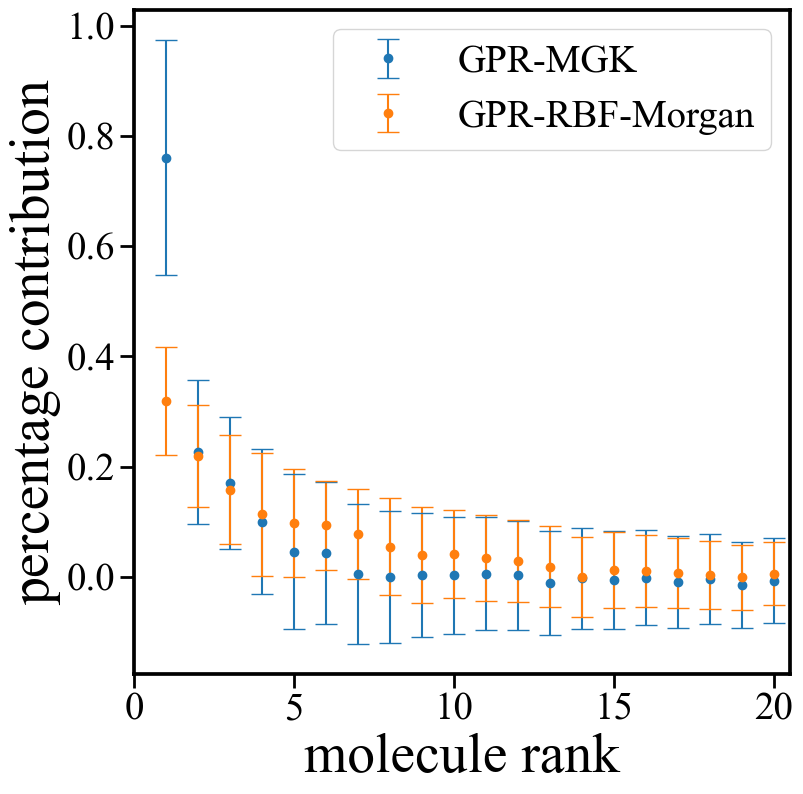

In [21]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 1, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

fig = plt.figure()
fig.tight_layout()

dxs = [0.16, 0.02]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.15, 0.02]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=2, length=10)
c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret])
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-MGK')

c_list_ = np.array([df.contribution_percentage.tolist() for df in df_interpret_morgan])
x = df_interpret[0].index + 1
y = np.mean(c_list_, axis=0)
y_err = np.std(c_list_, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-RBF-Morgan')

ax.set_xlim([0,20.5])
ax.set_xlabel('molecule rank')
ax.set_ylabel('percentage contribution')

ax.legend()
print(c_list[:, 0].mean(), c_list[:, 0].std())
print(c_list_[:, 0].mean(), c_list_[:, 0].std())
for i in range(20):
    print(i, stats.ttest_rel(c_list[:, i], c_list_[:, i], alternative='greater'))
for i in range(20):
    print(i, stats.ttest_rel(c_list[:, i], c_list_[:, i], alternative='less'))
    
"""
nx = 2
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret])
c_list = np.cumsum(c_list, axis=1)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-MGK')
#ax.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.5, )

c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret_morgan])
c_list = np.cumsum(c_list, axis=1)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-RBF-Morgan')

ax.set_xlim([0,40.5])
ax.set_xlabel('molecule index')
ax.set_ylabel('cumulative contribution (%)')
ax.legend()
"""
plt.savefig('figure3.png')
plt.savefig('toc_ma.svg', format='svg', dpi=1200)

# TOC figure

In [22]:
df = pd.read_csv('../results/raw_data/benzene/test.csv')
smiles = df.smiles[1]
mol = Chem.MolFromSmiles(smiles)
d2d = Draw.rdMolDraw2D.MolDraw2DSVG(250, 200)
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
text1 = d2d.GetDrawingText()
open('toc_m.svg', 'w').write(text1)

13583

smiles: CC(=C)C[NH2+]C[C@]1(CCCN(C1=O)Cc1cccc(c1F)F)O
ZINC: ZINC11999481
0.81707495
0.883134


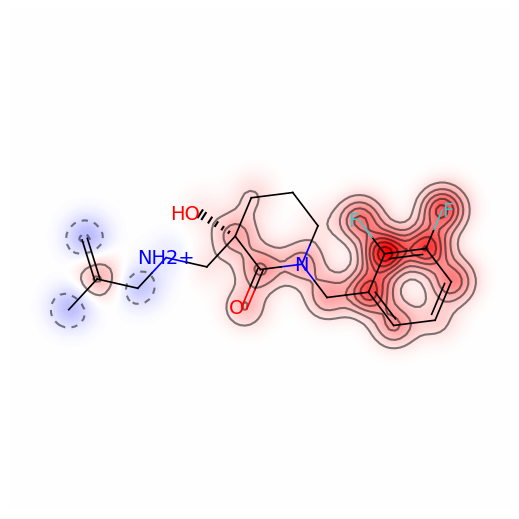

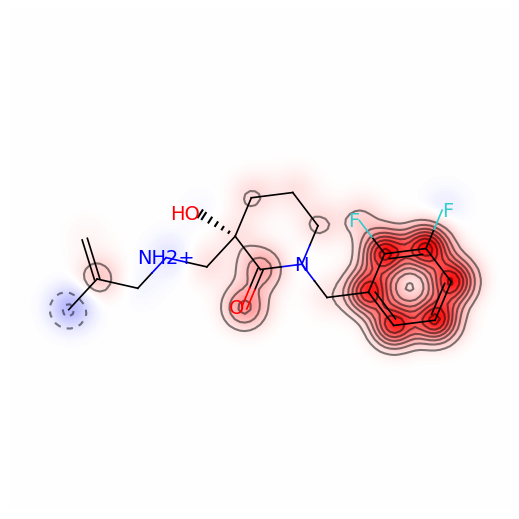

In [23]:
df_test = pd.read_csv('../results/raw_data/benzene/test.csv')

ids = [1]
for i in ids:
    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_1/9/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)
    smiles = df_test.smiles[i]
    print('smiles: %s' % smiles)
    print('ZINC: %s' % df_test.mol_id[i])
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    a = SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, alpha=0.5, size=(200, 200))
    # Draw.MolToImage(mol, size=(800, 500))

    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_100/0/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)

    smiles = df_test.smiles[i]
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    a = SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, size=(200, 200))
    # Draw.MolToImage(mol, size=(500, 300))
    a.savefig('toc_aa.svg', format='svg', dpi=1200, bbox_inches='tight')

<Figure size 800x800 with 0 Axes>

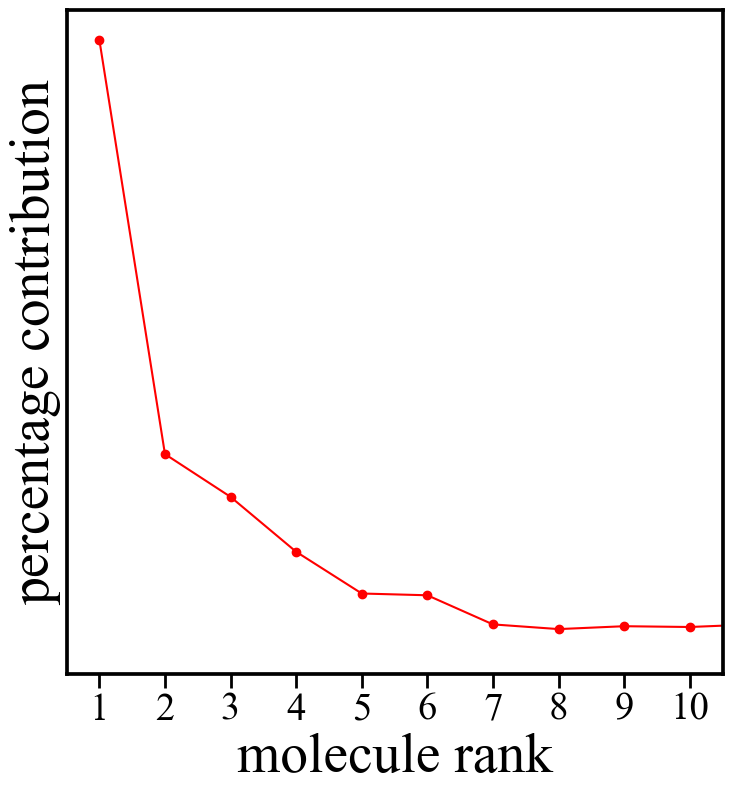

In [24]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 1, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

fig = plt.figure()
fig.tight_layout()

dxs = [0.16, 0.02]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.15, 0.02]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=2, length=10)
c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret])
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
ax.plot(x, y, 'o-', c='r', label='GPR-MGK')


ax.set_xlim([0.5,10.5])
ax.set_xticks(range(1, 11))
ax.set_yticks([100])
ax.set_xlabel('molecule rank')
ax.set_ylabel('percentage contribution')

plt.savefig('toc_ma.svg', format='svg', dpi=1200)